# TRABAJO GRUPAL ANÁLISIS MULTIVARIANTE
### Global poverty and inequality dataset

**Kaggle link**: https://www.kaggle.com/datasets/utkarshx27/global-poverty-and-inequality-dataset/data?select=pip_codebook.csv

Mapa del mundo coloreable: https://naturaldisasters.ai/posts/python-geopandas-world-map-tutorial/

### Tabla de Contenidos: <a class="anchor" id="index"></a>

<div class="alert" style="margin-top: 20px">

1. [Cargar datos e importar librerías](#seccion_1)<br>

2. [Análisis descriptivo por subrgupos y transformación de variables](#seccion_2)<br>

3. [Análisis e imputación de datos perdidos](#seccion_3)<br>

4. [Análisis de correlaciones y reducción de la dimensionalidad](#seccion_4)<br>

5. [Análisis cluster](#seccion_5)<br>
</div>


### 1. Cargar datos e importar librerías <a class="anchor" id="seccion_1"></a>



In [145]:
# py -m pip install pandas
# py -m pip install numpy
# py -m pip install matplotlib
# py -m pip install plotly
# py -m pip install seaborn

In [146]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import plotly.graph_objects as go
import plotly.subplots as sp
from scipy.stats import zscore
from scipy.stats import f

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from continents import continent_dict 
from handleData import handleData

In [147]:
# Load the  dataset
# path = 'C:\\Users\\carlo\\OneDrive - UPV\\ESCRITORIO CARLOS\\UPV\\Máster\\Cuatri A\\Análisis Multivariante\\'
path = 'C:\\Users\\carlo\\OneDrive\\Documentos\\GitHub\\Multivariante\\'
file_name = 'pip_dataset.csv'
data = pd.read_csv(path + file_name)

# Create continent column
data['continent'] = data['country'].map(continent_dict) # create column continet
data = data[['country', 'continent'] + [col for col in data.columns if col not in ['country', 'continent']]]
data.head()

country continent  year reporting_level welfare_type  ppp_version  \
0  Albania    Europe  1996        national  consumption         2011   
1  Albania    Europe  2002        national  consumption         2011   
2  Albania    Europe  2005        national  consumption         2011   
3  Albania    Europe  2008        national  consumption         2011   
4  Albania    Europe  2012        national  consumption         2011   

   survey_year  survey_comparability  headcount_ratio_international_povline  \
0       1996.0                   0.0                               0.920669   
1       2002.0                   1.0                               1.570843   
2       2005.0                   1.0                               0.860527   
3       2008.0                   1.0                               0.313650   
4       2012.0                   1.0                               0.849754   

   headcount_ratio_lower_mid_income_povline  ...  decile8_thr  decile9_thr  \
0                                 11.174149  ...         8.85        10.92   
1                                 14.132118  ...         8.83        11.58   
2                                  8.715685  ...        10.02        12.78   
3                                  5.250542  ...        10.74        13.62   
4                                  6.182414  ...        10.52        13.26   

       gini       mld  polarization  palma_ratio  s80_s20_ratio  \
0  0.270103  0.119104      0.241293     0.928335       3.945872   
1  0.317390  0.164812      0.268982     1.215056       4.831625   
2  0.305957  0.154413      0.254529     1.142718       4.662236   
3  0.299847  0.148893      0.247311     1.114657       4.395911   
4  0.289605  0.138417      0.249988     1.041193       4.272573   

   p90_p10_ratio  p90_p50_ratio  p50_p10_ratio  
0       3.568627       1.889273       1.888889  
1       3.979381       2.090253       1.903780  
2       3.872727       1.978328       1.957576  
3       3.574803       1.956897       1.826772  
4       3.632877       1.941435       1.871233  

[5 rows x 109 columns]

In [148]:
data.drop("survey_year", axis= 1, inplace=True)
feat_names = data.columns
feat_cat = list(feat_names[0:2]) + list(feat_names[3:5])
feat_num = [feat for feat in feat_names if feat not in feat_cat]

### 2. Análisis descriptivo por subrgupos y transformación de variables <a class="anchor" id="seccion_2"></a>
Para facilitar el análisis, creamos diferentes subgrupos de características según su categoría.


In [149]:
data_headcount = data.iloc[:, 8:29]
data_avg_shortfall = data.iloc[:, 29:40]
data_total_shortfall = data.iloc[:, 40:51]
data_income_poverty_gap = data.iloc[:, 51:70]
data_decile = data.iloc[:, 70:100]
data_end = data.iloc[:, 100:109]

datasets = {
    'Headcount': data_headcount,
    'Average_Shortfall': data_avg_shortfall,
    'Total_Shortfall': data_total_shortfall,
    'Income_Poverty_Gap': data_income_poverty_gap,
    'Deciles': data_decile,
    'Inequality_Metrics': data_end
}

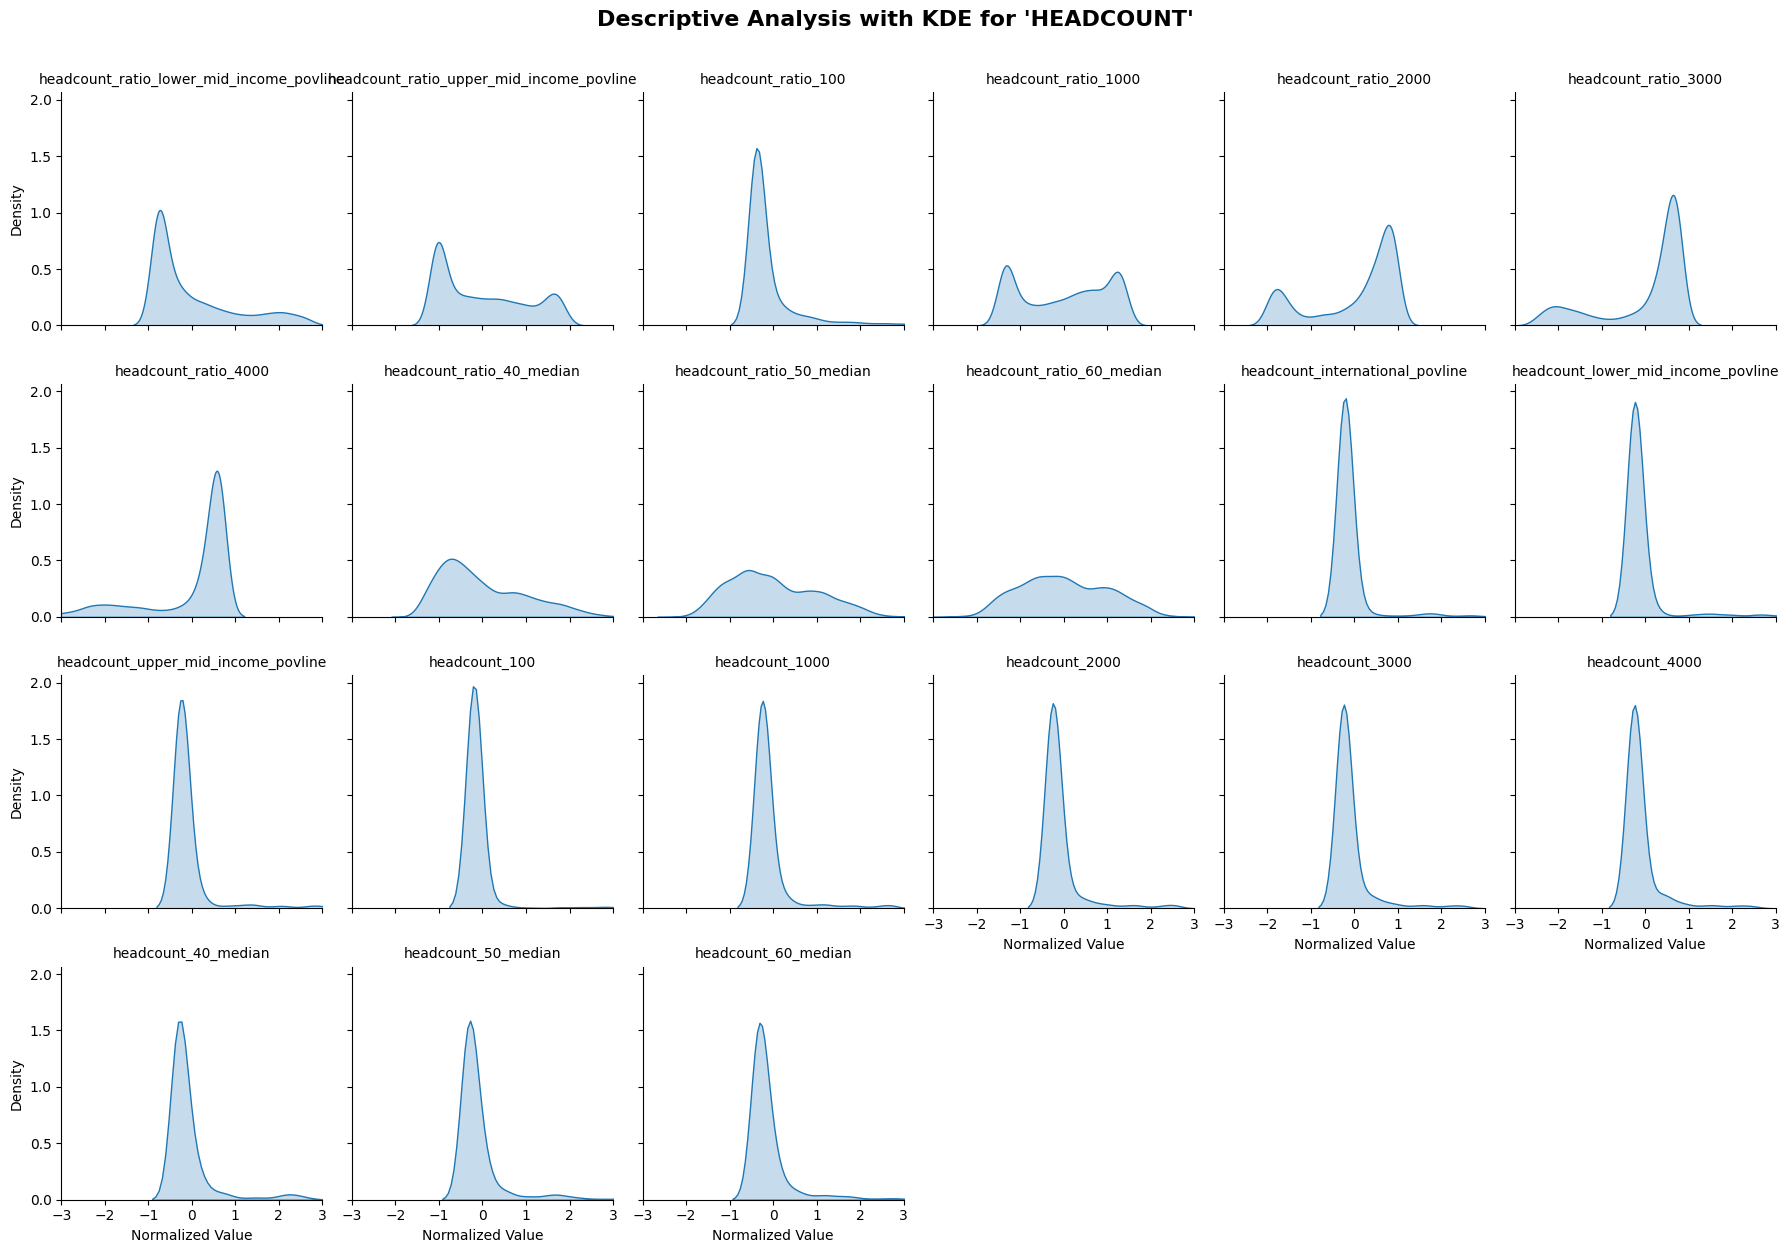

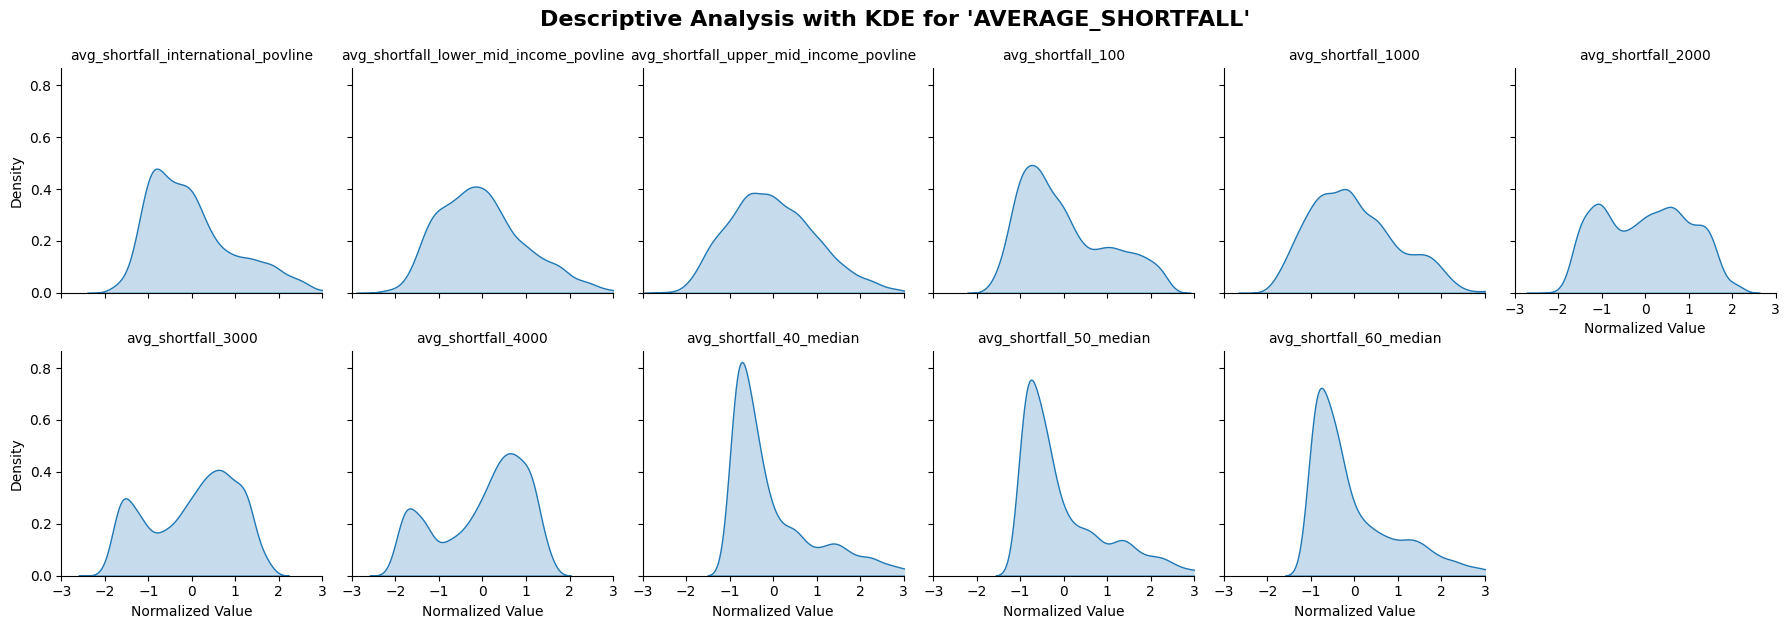

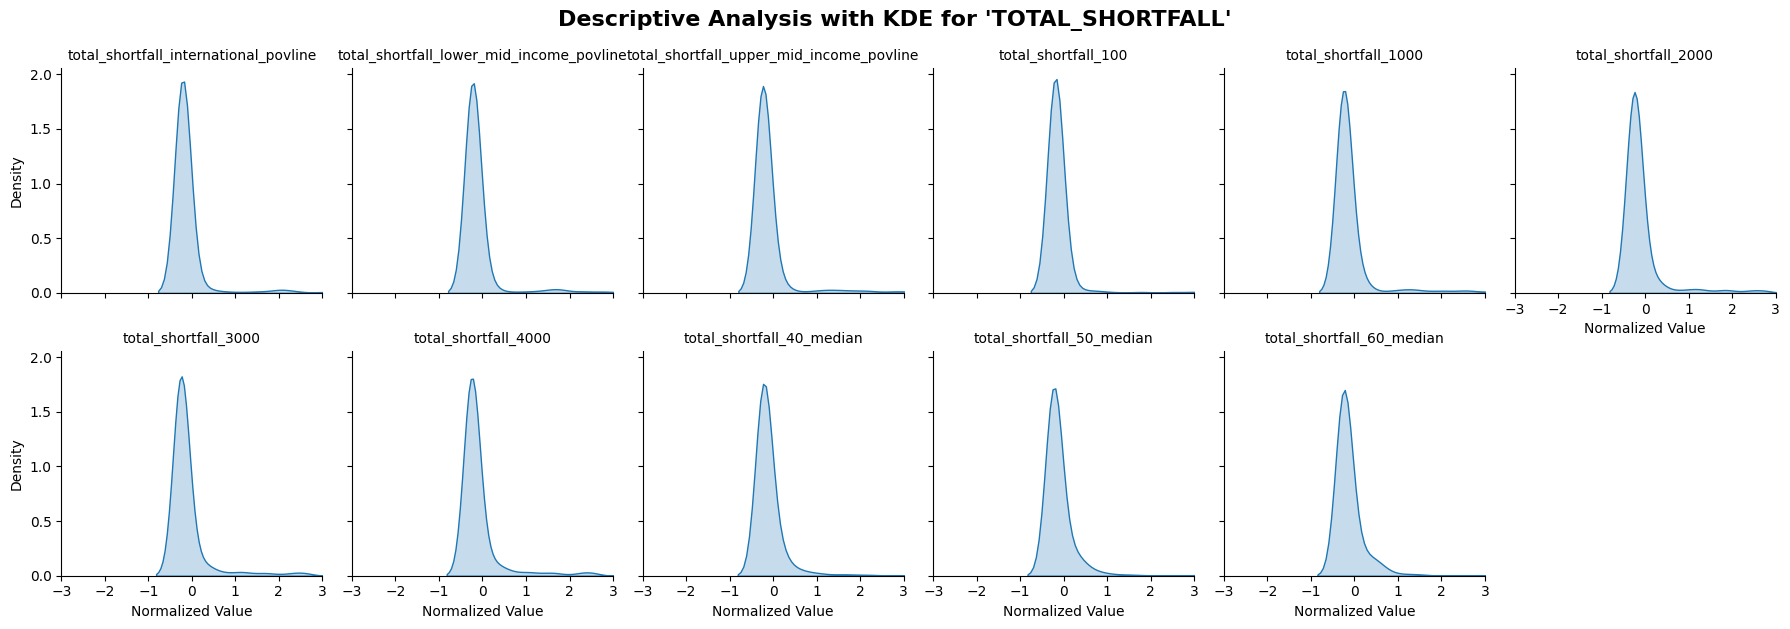

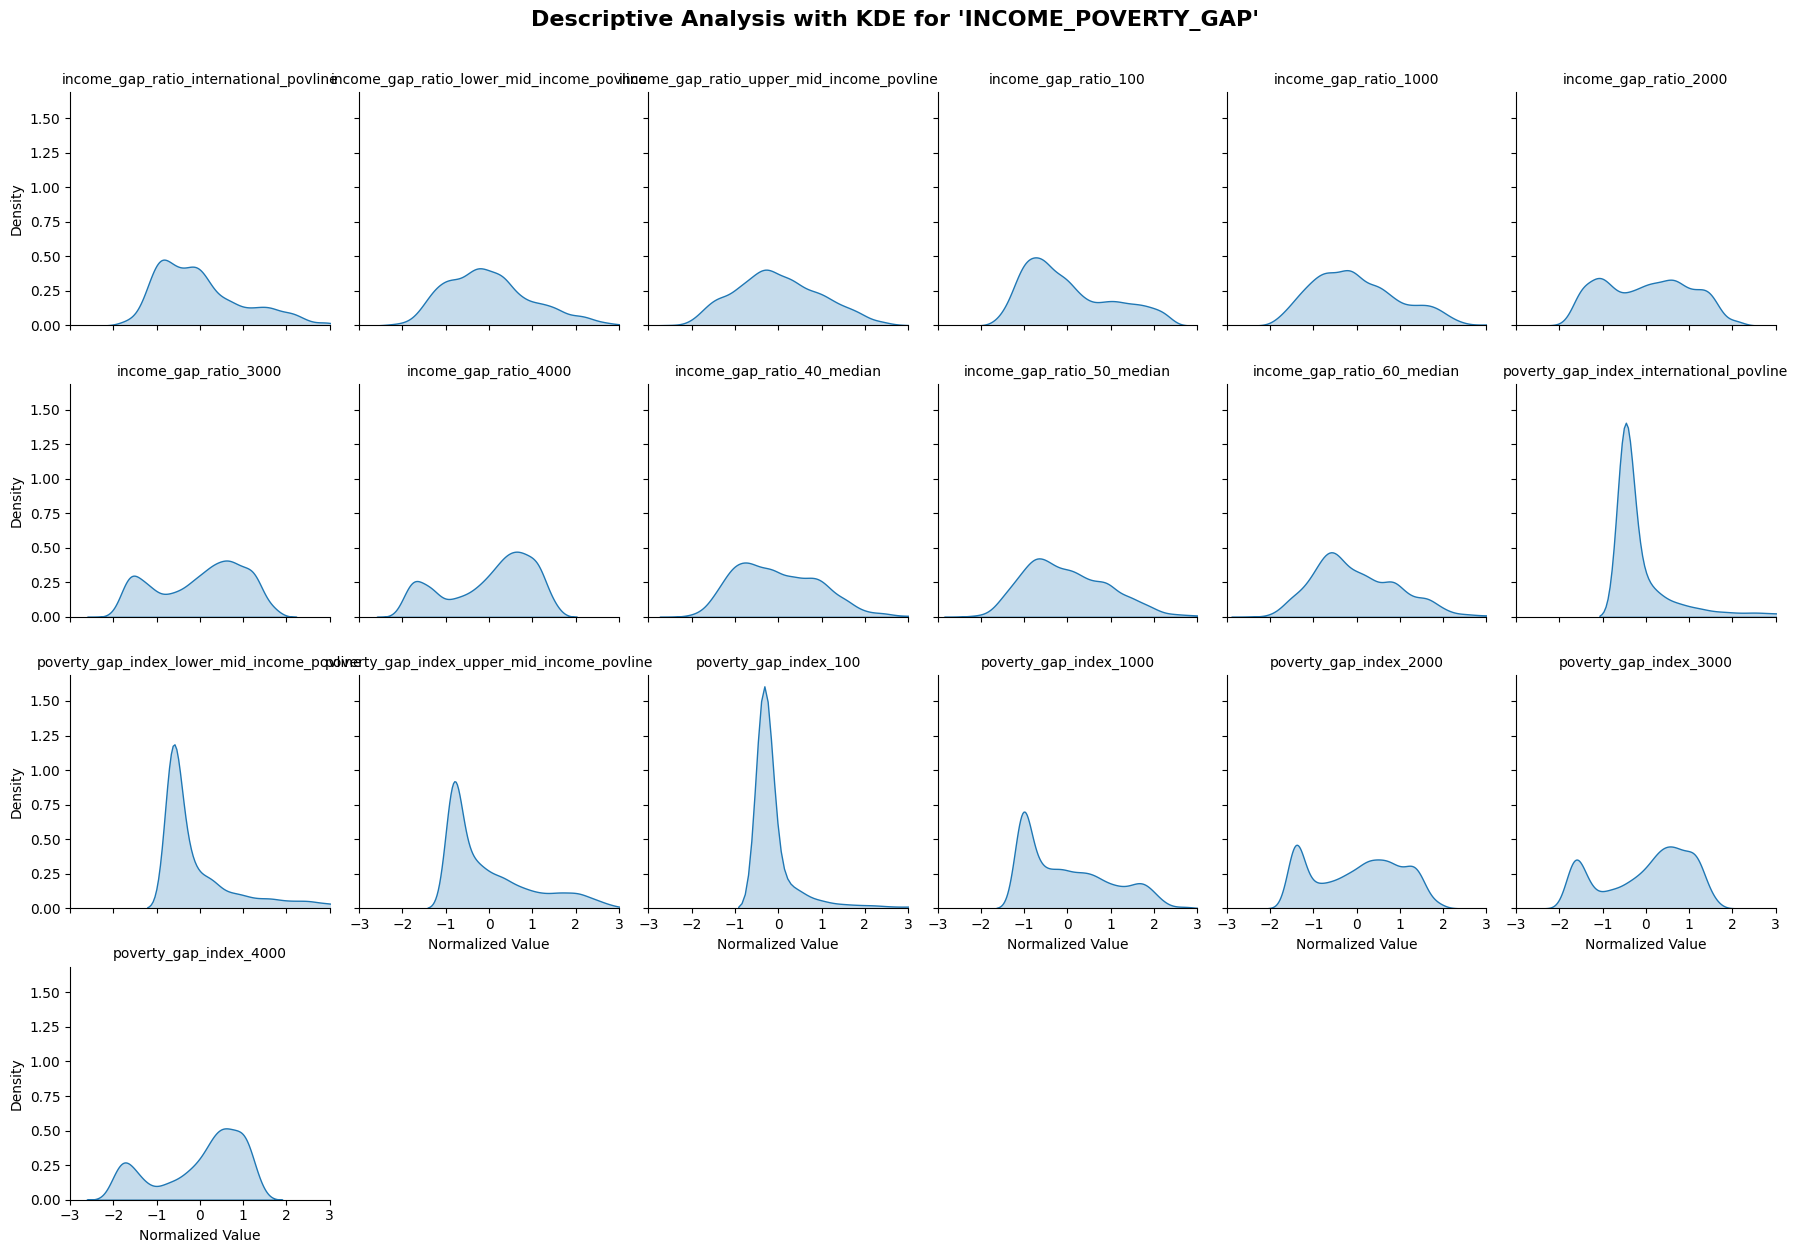

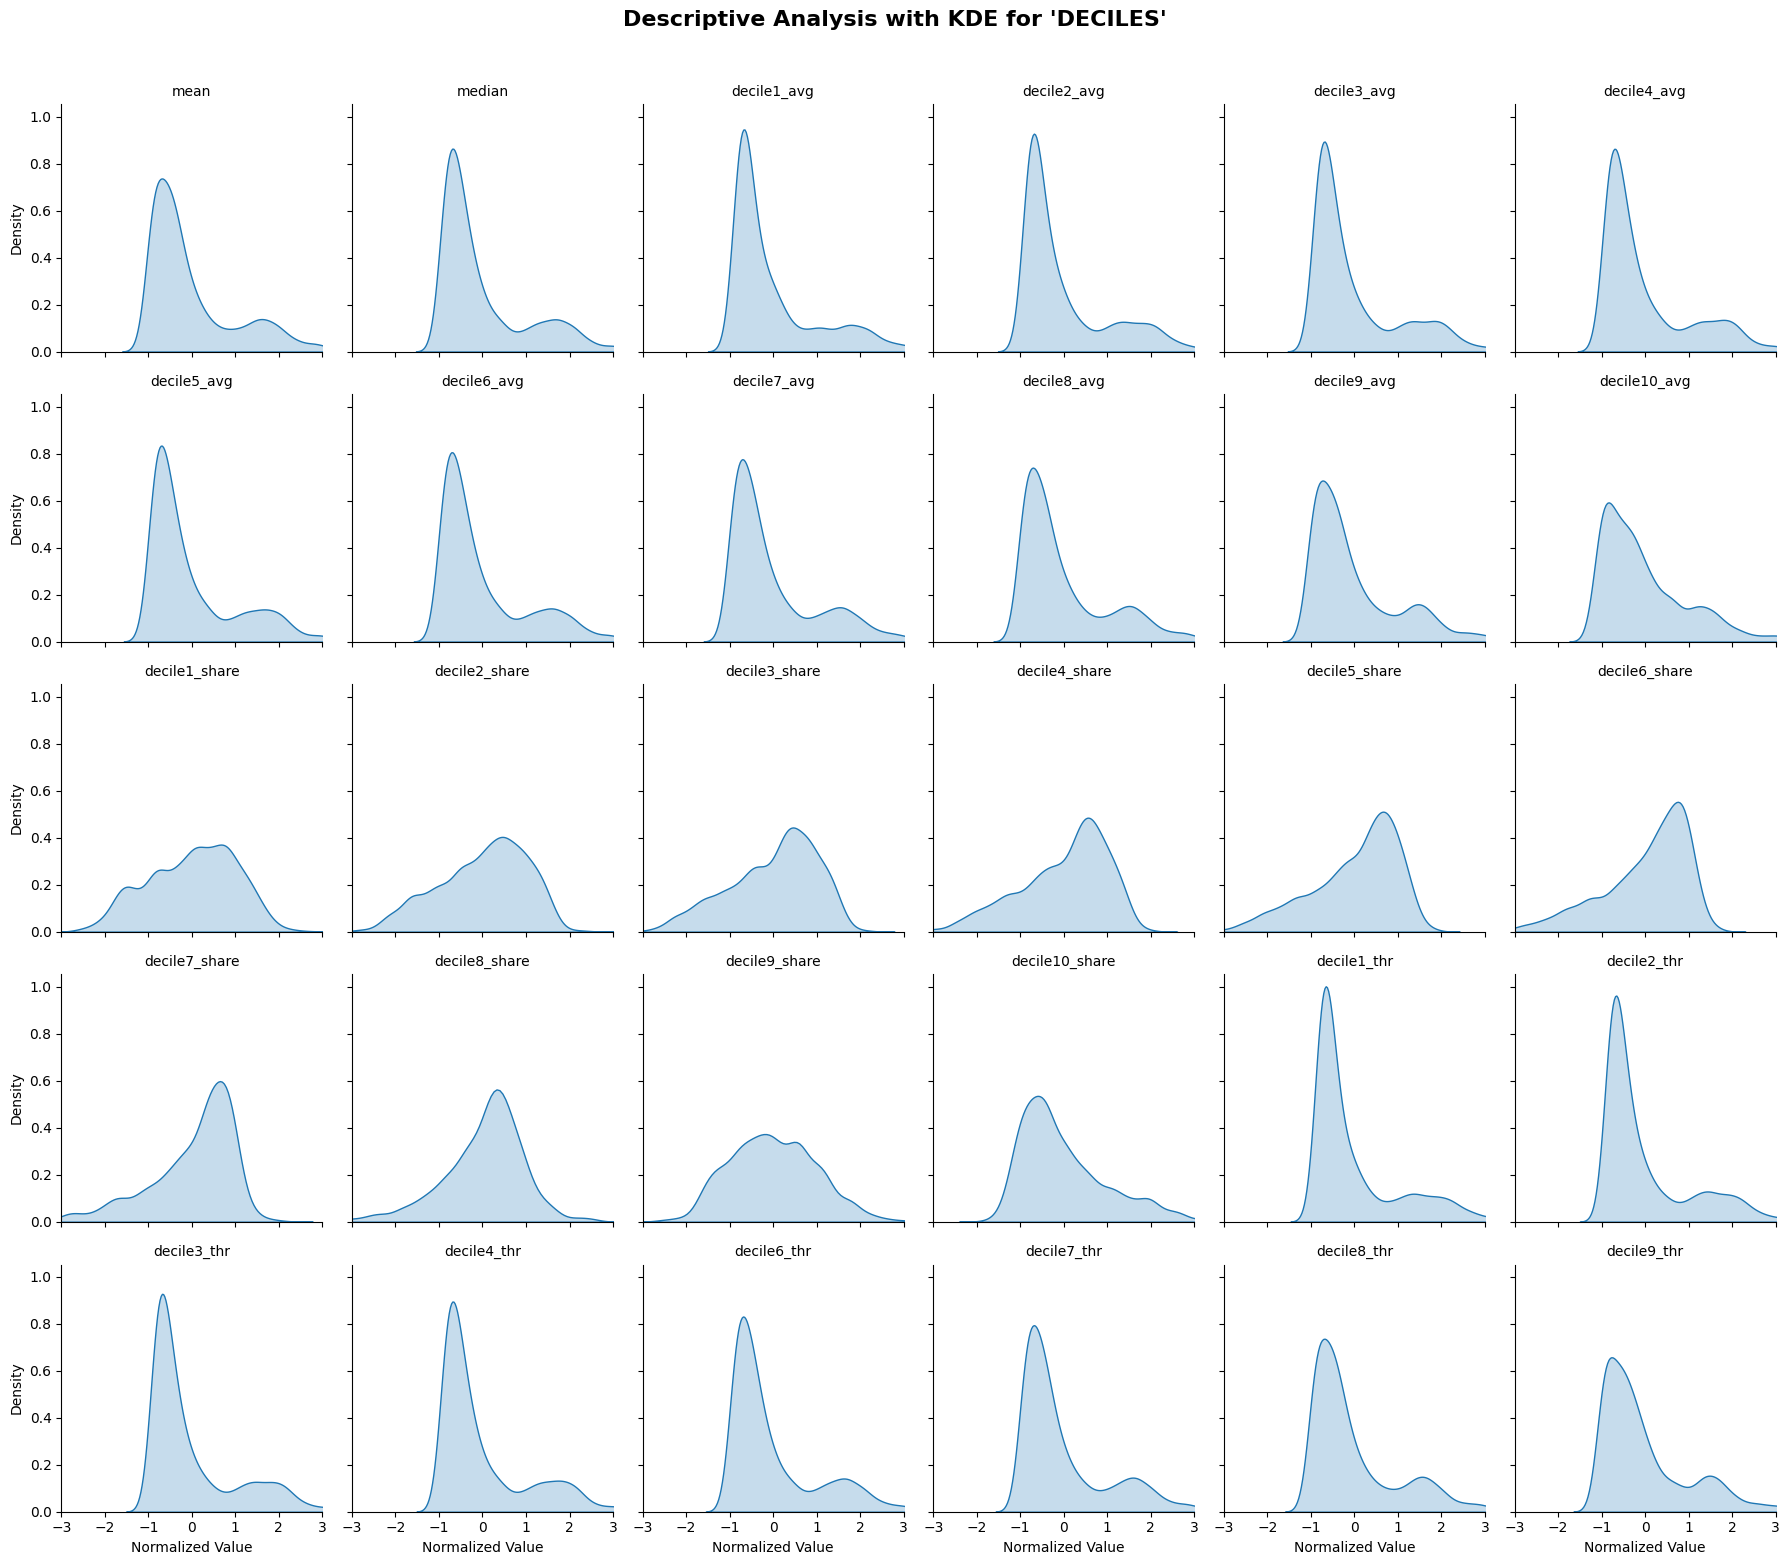

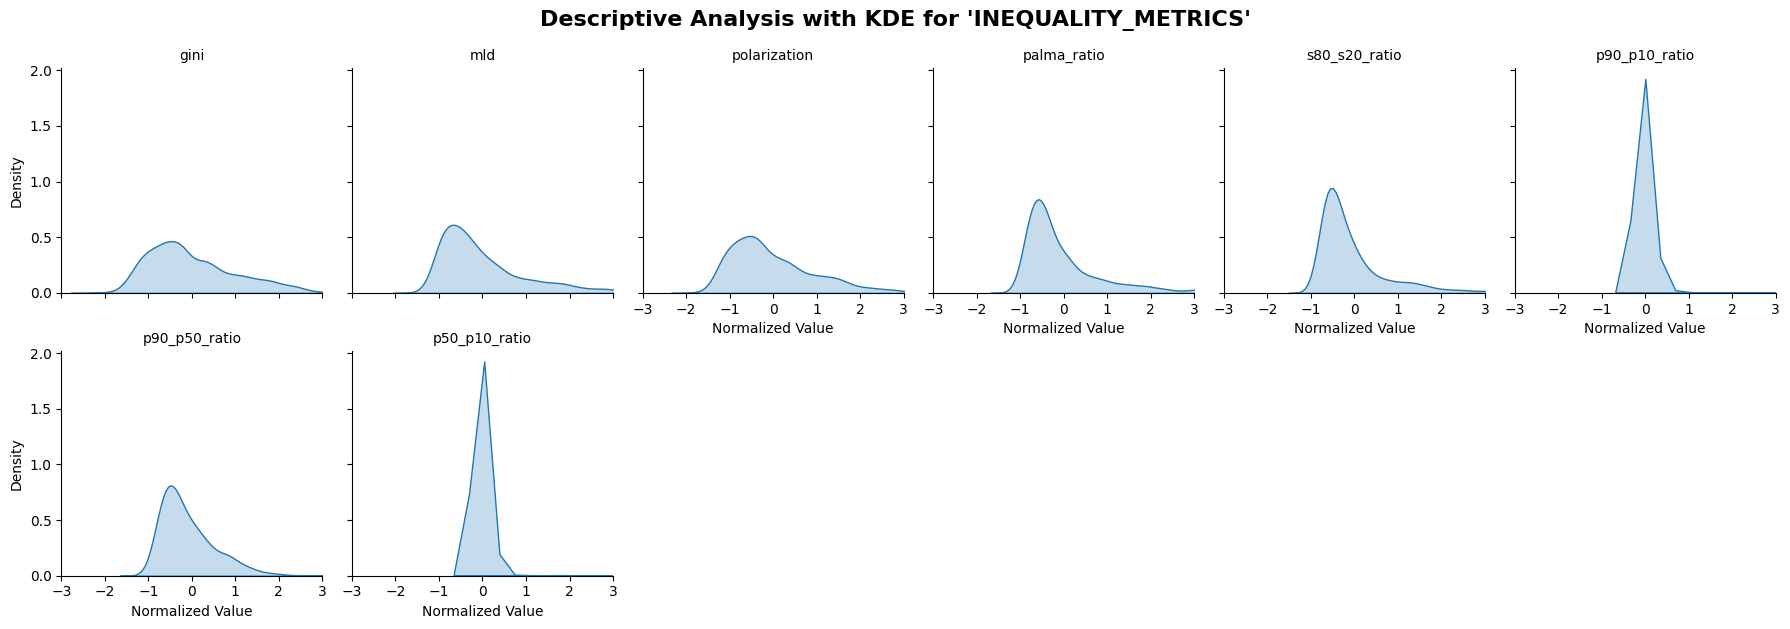

In [150]:
for name, dataset in datasets.items():
    # Normalize the dataset and transform it to long format
    data_scaled = pd.DataFrame(StandardScaler().fit_transform(dataset), columns=dataset.columns)
    data_melted = data_scaled.melt(var_name='variable', value_name='value')

    # Create the KDE plots grid
    g = sns.FacetGrid(data_melted, col="variable", col_wrap=6, height=3, aspect=1)
    g.map(sns.kdeplot, "value", fill=True)

    g.set(xlim=(-3, 3))  # Adjust X for a narrower range if the data is normalized
    g.set_titles("{col_name}")
    g.set_axis_labels("Normalized Value", "Density")
    g.tight_layout()
    g.fig.suptitle(f"Descriptive Analysis with KDE for '{name.upper()}'", y=1.04, fontsize=16, weight='bold')

    plt.show()

### 3. Análisis e imputación de datos perdidos <a class="anchor" id="seccion_3"></a>

Observar el porcentaje de datos perdidos por columna

C:\Users\carlo\AppData\Local\Temp\ipykernel_27248\3009443849.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Percentage of Missing Data", y=missing_table.index, data=missing_table, palette="viridis")


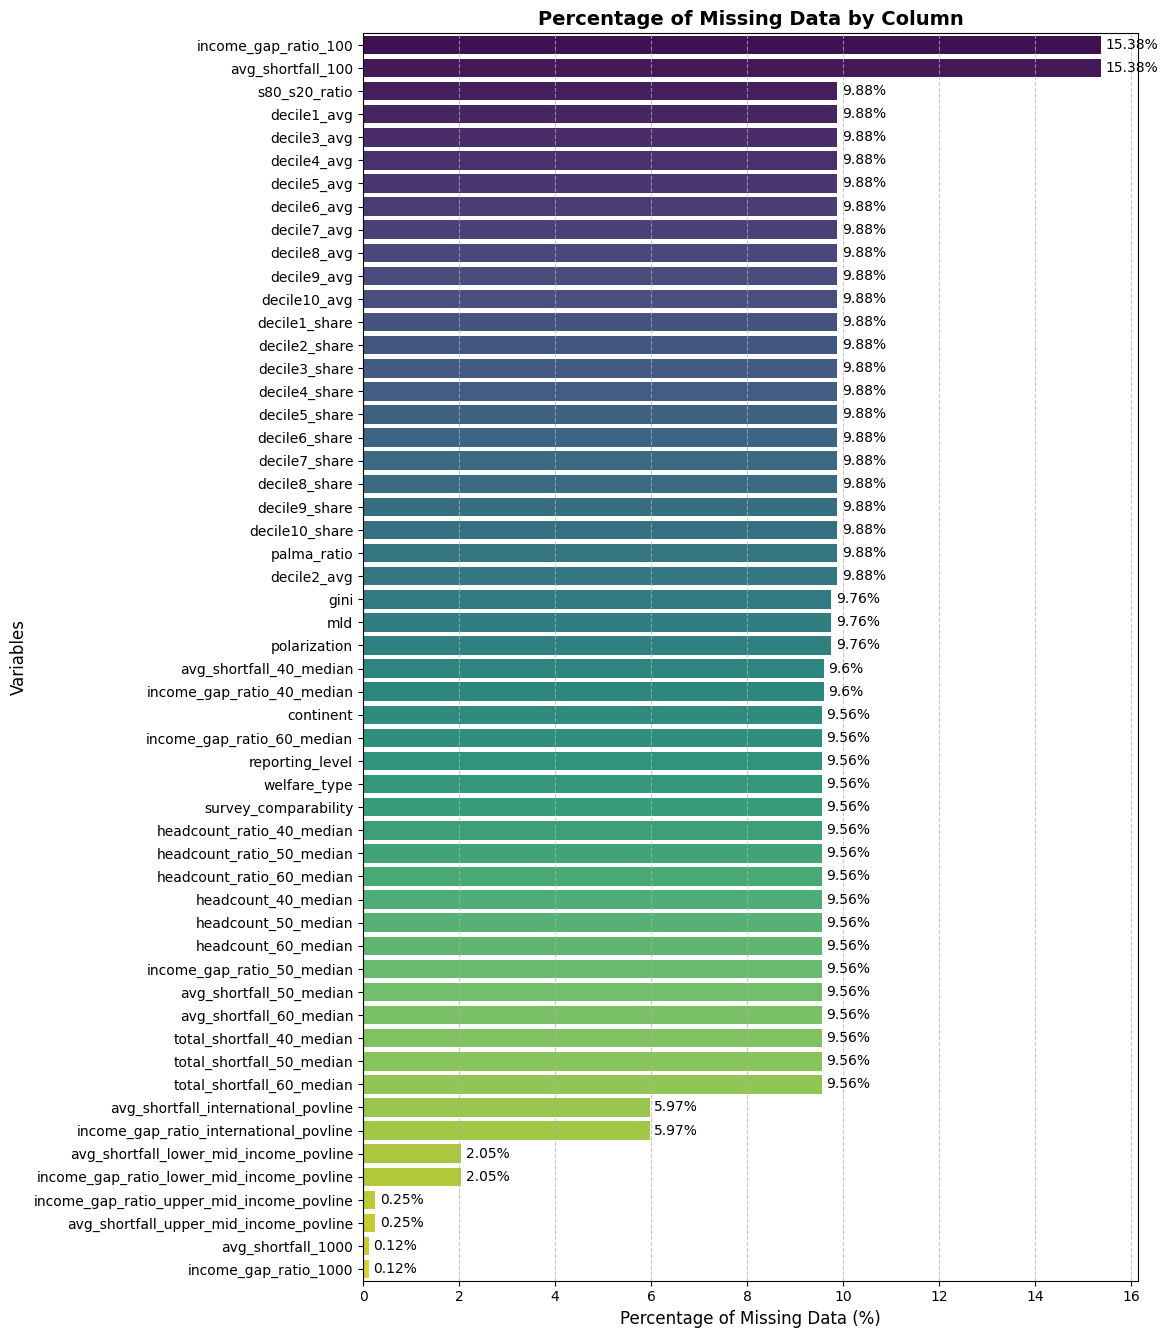

In [151]:
# Calculate percentage of missing data with 2 decimals
missing_percentages = data.isnull().mean() * 100
missing_percentages = missing_percentages[missing_percentages > 0].round(2)
missing_table = pd.DataFrame(missing_percentages, columns=["Percentage of Missing Data"])
missing_table = missing_table.sort_values(by="Percentage of Missing Data", ascending=False)

plt.figure(figsize=(10, max(6, len(missing_table) * 0.3)))
sns.barplot(x="Percentage of Missing Data", y=missing_table.index, data=missing_table, palette="viridis")
plt.xlabel("Percentage of Missing Data (%)", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.title("Percentage of Missing Data by Column", fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show percentages in each bar
for index, value in enumerate(missing_table["Percentage of Missing Data"]):
    plt.text(value + 0.1, index, f"{value}%", va='center', fontsize=10)

plt.show()

Eliminar los datos perdidos de los territorios poco claros (Worlwide, High income contries, Latin America and the Caribbean, ... ).

In [152]:
# Filtrar y mostrar los valores únicos de los países cuyo continente es NaN
territories_with_nan_continent = data[data['continent'].isna()]['country'].unique()

# Mostrar los resultados
print("Territorios con continente NaN:")
print(territories_with_nan_continent)

Territorios con continente NaN:
['East Asia and Pacific' 'Europe and Central Asia' 'High income countries'
 'Latin America and the Caribbean' 'Middle East and North Africa'
 'South Asia' 'Sub-Saharan Africa' 'World']


Number of rows with missing values: 482


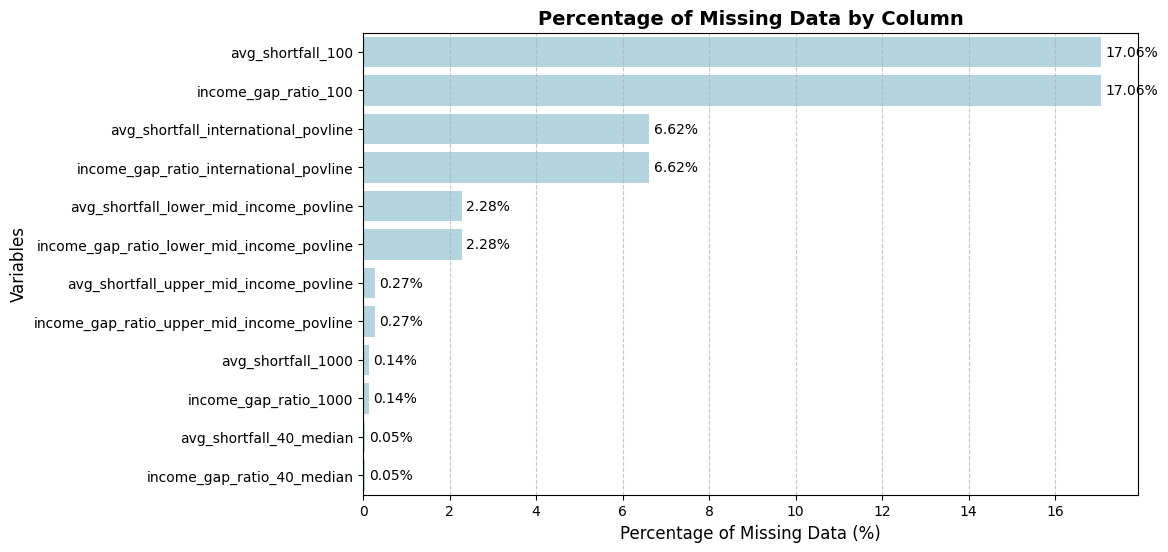

In [153]:
shape_1 = data.shape
data.dropna(subset=['reporting_level', 'welfare_type','decile10_share'], inplace=True)
shape_2 = data.shape
print(f"Number of rows with missing values: {shape_1[0] - shape_2[0]}")

# Calculate percentage of missing data with 2 decimals
missing_percentages = data.isnull().mean() * 100
missing_percentages = missing_percentages[missing_percentages > 0].round(2)
missing_table = pd.DataFrame(missing_percentages, columns=["Percentage of Missing Data"])
missing_table = missing_table.sort_values(by="Percentage of Missing Data", ascending=False)

plt.figure(figsize=(10, max(6, len(missing_table) * 0.3)))
sns.barplot(x="Percentage of Missing Data", y=missing_table.index, data=missing_table, color='lightblue')
plt.xlabel("Percentage of Missing Data (%)", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.title("Percentage of Missing Data by Column", fontsize=14, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show percentages in each bar
for index, value in enumerate(missing_table["Percentage of Missing Data"]):
    plt.text(value + 0.1, index, f"{value}%", va='center', fontsize=10)

plt.show()

Antes de imputar los datos perdidos restantes, solucionamos los outliers. Para facilitar el análisis, creamos diferentes subgrupos de características según su categoría.

In [154]:
data_headcount = data.iloc[:, 8:29]
data_avg_shortfall = data.iloc[:, 29:40]
data_total_shortfall = data.iloc[:, 40:51]
data_income_poverty_gap = data.iloc[:, 51:70]
data_decile = data.iloc[:, 70:100]
data_end = data.iloc[:, 100:109]

datasets = {
    'Headcount': data_headcount,
    'Average_Shortfall': data_avg_shortfall,
    'Total_Shortfall': data_total_shortfall,
    'Income_Poverty_Gap': data_income_poverty_gap,
    'Deciles': data_decile,
    'Inequality_Metrics': data_end
}

Number of outliers replaced with NaN: 1067
Percentage of cells replaced: 0.22%


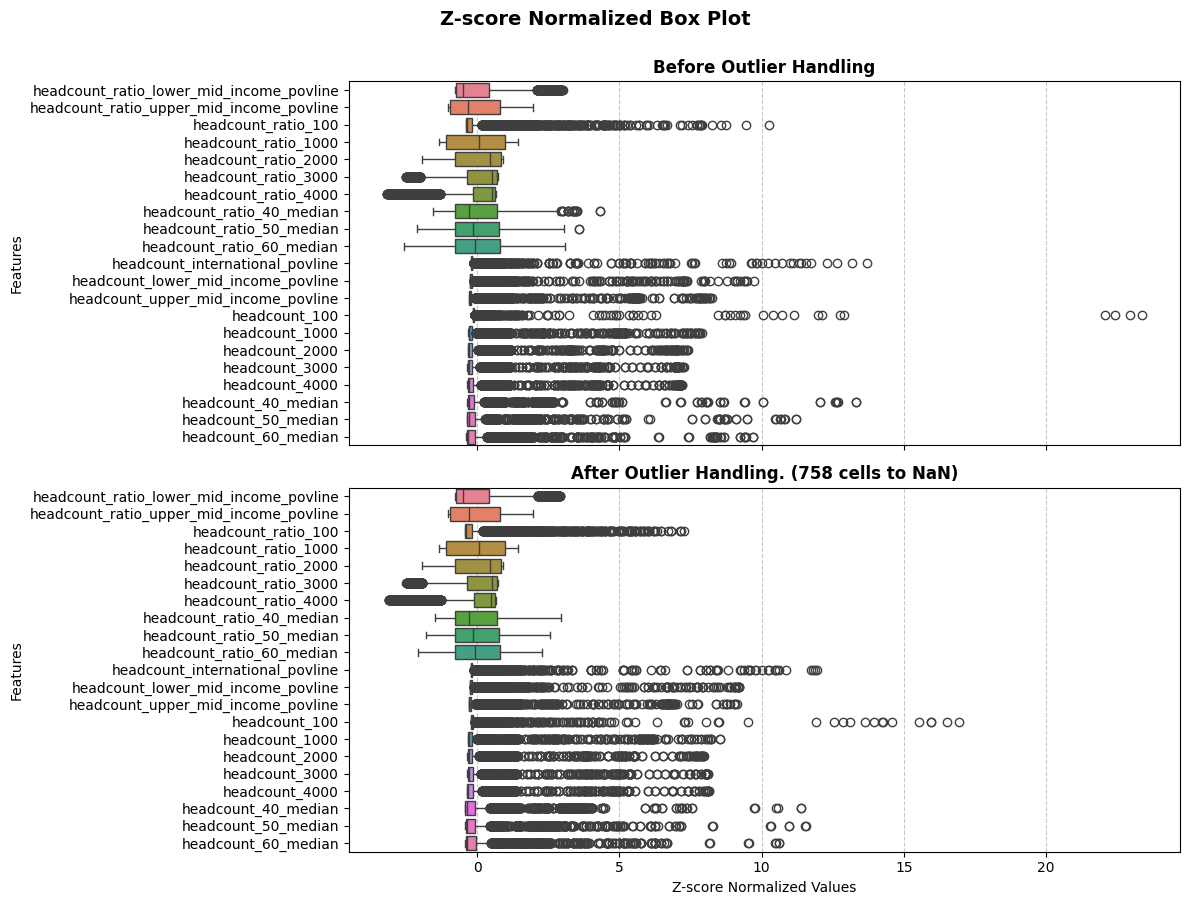

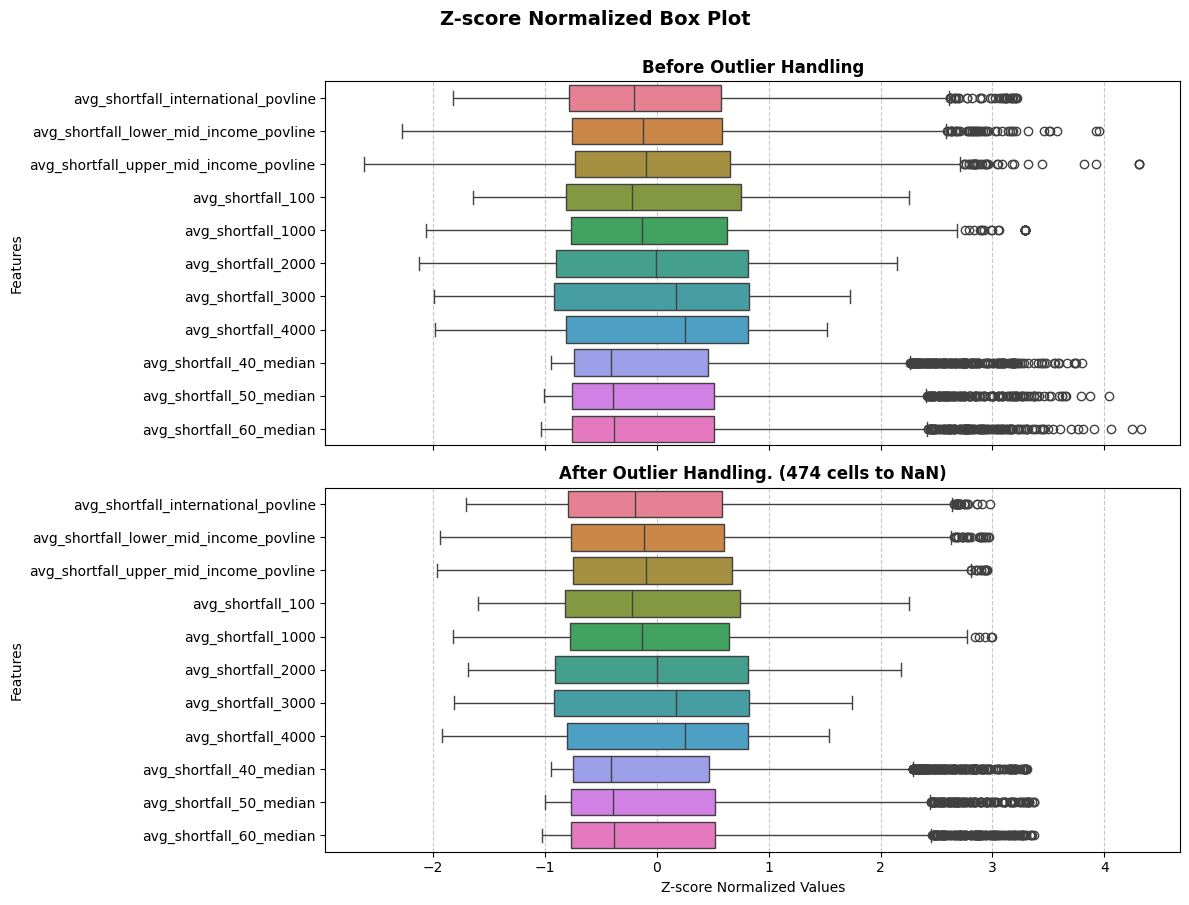

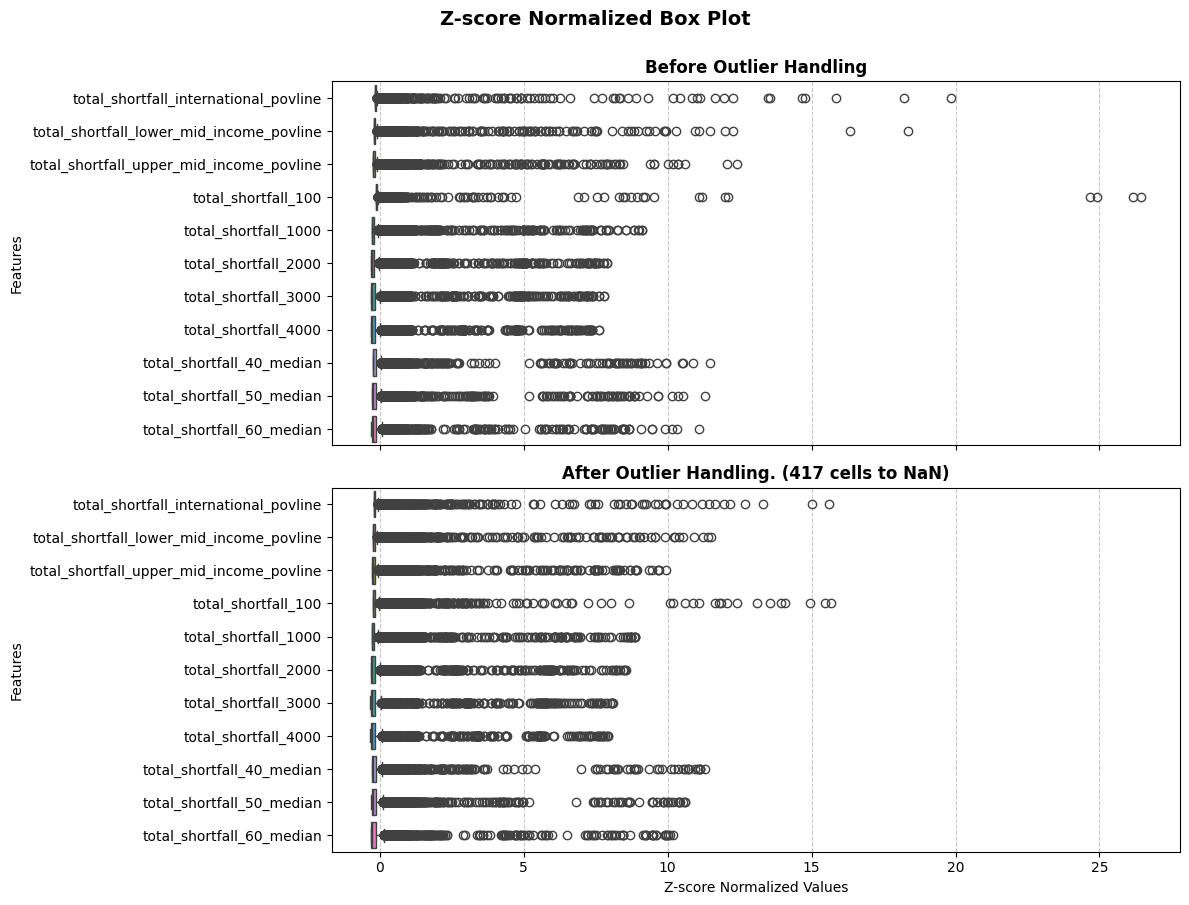

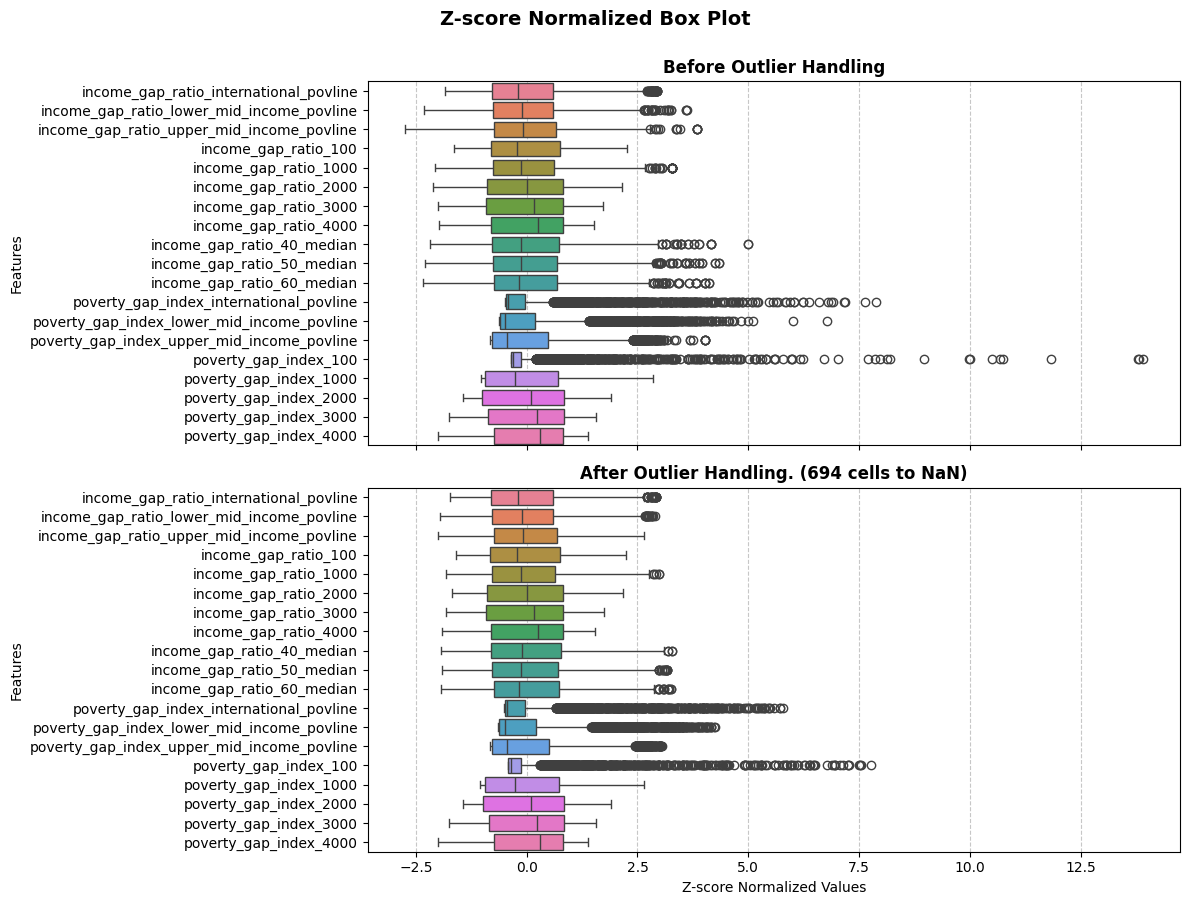

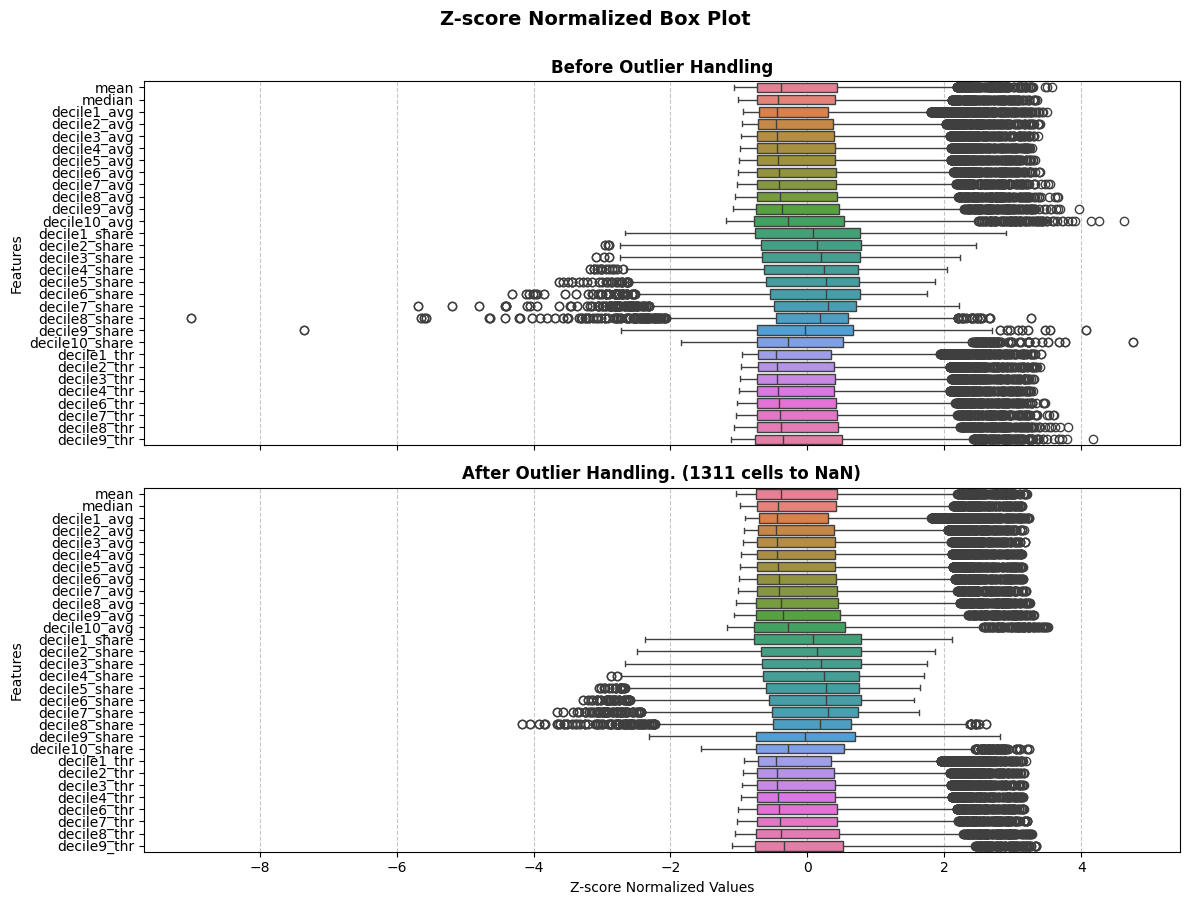

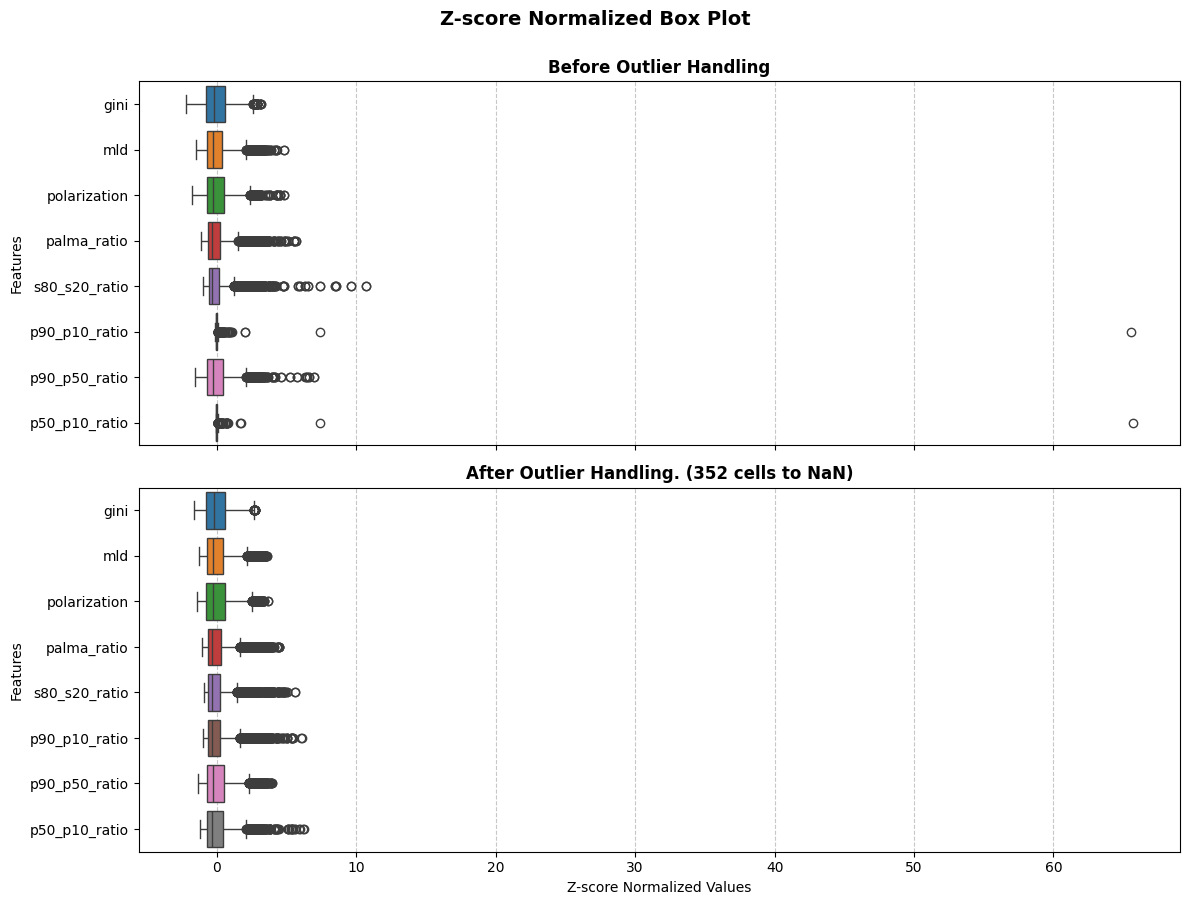

In [155]:
# Apply outlier handling to 'data'
data, data_outliers_replaced, perc_replaced = handleData.replace_outliers_with_nan(data, confidence_interval=0.9973)
print(f"Number of outliers replaced with NaN: {data_outliers_replaced}")
print(f"Percentage of cells replaced: {perc_replaced:.2f}%")


# Apply outlier handling to each dataset in the dictionary and visualize with Z-score normalization
for name, dataset in datasets.items():

    # Normalize without handling outliers
    normalized_dataset_no_outliers = dataset.apply(zscore, nan_policy='omit')
    
    # Replace outliers with NaN in each dataset and normalize again
    datasets[name], cells_replaced, _ = handleData.replace_outliers_with_nan(normalized_dataset_no_outliers, confidence_interval=0.99)
    normalized_dataset_outliers_handled = datasets[name].apply(zscore, nan_policy='omit')
    
    # Create a figure with 2 subplots (one above the other) to compare before and after handling outliers
    fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
    
    # Plot Z-score normalized dataset before outlier handling
    sns.boxplot(data=normalized_dataset_no_outliers, orient="h", ax=axes[0])
    axes[0].set_title(f"Before Outlier Handling", fontdict={'weight': 'bold', 'size': 12})
    axes[0].set_xlabel("Z-score Normalized Values")
    axes[0].set_ylabel("Features")
    axes[0].grid(axis='x', linestyle='--', alpha=0.7)
    
    # Plot Z-score normalized dataset after outlier handling
    sns.boxplot(data=normalized_dataset_outliers_handled, orient="h", ax=axes[1])
    axes[1].set_title(f"After Outlier Handling. ({cells_replaced} cells to NaN)", fontdict={'weight': 'bold', 'size': 12})
    axes[1].set_xlabel("Z-score Normalized Values")
    axes[1].set_ylabel("Features")
    axes[1].grid(axis='x', linestyle='--', alpha=0.7)

    
    # Adjust the layout and add suptitle
    plt.suptitle(f"Z-score Normalized Box Plot", y=1, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Show the plot
    plt.show()

Imputar con MICE regresión lineal los missing restantes

In [156]:
# Solve numerical missing data
imputer = IterativeImputer(estimator=LinearRegression(), random_state=1, max_iter=10)
data[feat_num] = imputer.fit_transform(data[feat_num])
data = data.reset_index(drop=True)

c:\Users\carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Detectar y eliminar los outliers multivariantes mediante un test Hotelling T2 (como t de Student pero multivariante). El test mide la distancia de una observación en un el conjunto de datos multivariante respecto de la media global, considerando la estructura de correalación y varianza. Ajusta las distancias considerando las covarianzas.

Number of multivariate outliers detected: 513
The cleaned dataset now has 3882 rows.


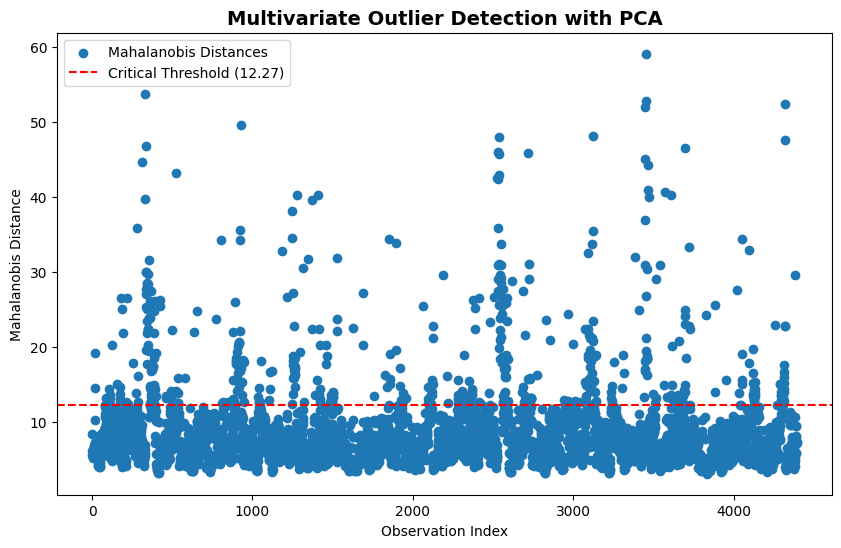

In [157]:
# Select the numeric columns and apply PCA (ensure covariance matrix invertible)
numeric_data = data.iloc[:, 6:109]
pca = PCA()
pca_data = pca.fit_transform(numeric_data)  

# Compute the mean and covariance matrix in the PCA space
mean_vector = np.mean(pca_data, axis=0)
cov_matrix = np.cov(pca_data, rowvar=False)

# Calculate Hotelling's T² statistic in the PCA space
inv_cov_matrix = np.linalg.inv(cov_matrix) # inverse of the covariance matrix 
centered_data = pca_data - mean_vector
T2_statistics = np.einsum('ij,jk,ik->i', centered_data, inv_cov_matrix, centered_data)  # Efficient T² calculation

# Step 5: Determine the critical threshold
n, p = numeric_data.shape
threshold = f.ppf(0.9973, dfn=p, dfd=n-p) * p * (n-1) / (n-p) 

outliers = np.where(T2_statistics > threshold)[0]
num_outliers = len(outliers)
print(f"Number of multivariate outliers detected: {num_outliers}")

data_cleaned = data.drop(index=outliers)
print(f"The cleaned dataset now has {data_cleaned.shape[0]} rows.")

# Mahalanobis distance plot to visualize multivariate anomalies
mahalanobis_distances = np.sqrt(T2_statistics)
critical_value = np.sqrt(threshold)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(mahalanobis_distances)), mahalanobis_distances, label="Mahalanobis Distances")
plt.axhline(y=critical_value, color='r', linestyle='--', label=f"Critical Threshold ({critical_value:.2f})")
plt.xlabel("Observation Index")
plt.ylabel("Mahalanobis Distance")
plt.title("Multivariate Outlier Detection with PCA", fontsize=14, weight='bold')
plt.legend()
plt.show()


In [158]:
data_headcount = data.iloc[:, 7:29]
data_avg_shortfall = data.iloc[:, 29:40]
data_total_shortfall = data.iloc[:, 40:51]
data_income_poverty_gap = data.iloc[:, 51:70]
data_decile = data.iloc[:, 70:100]
data_end = data.iloc[:, 100:109]

datasets = {
    'Headcount': data_headcount,
    'Average_Shortfall': data_avg_shortfall,
    'Total_Shortfall': data_total_shortfall,
    'Income_Poverty_Gap': data_income_poverty_gap,
    'Deciles': data_decile,
    'Inequality_Metrics': data_end
}

### 4. Análisis de correlaciones y reducción de la dimensionalidad <a class="anchor" id="seccion_4"></a>


Realizar un análisis de correlaciones y obtener un gráfico de pareto tras PCA por subgrupos.

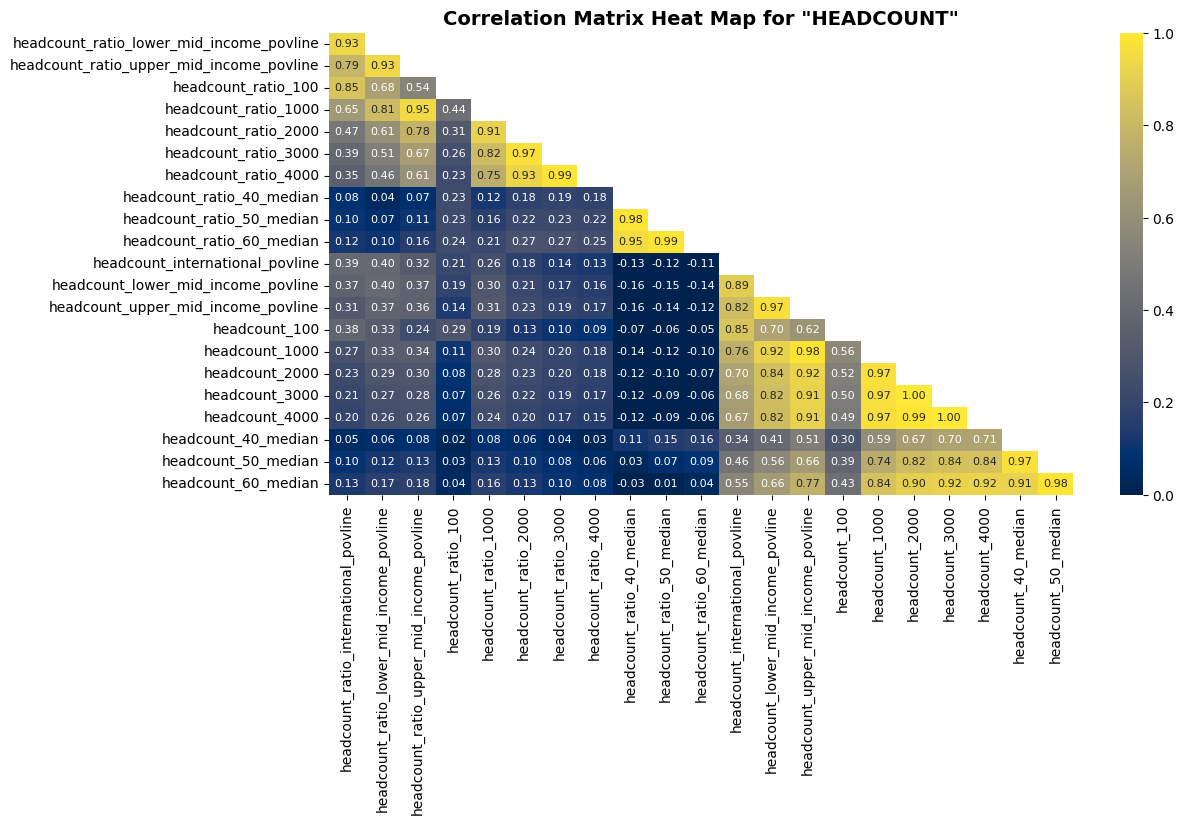

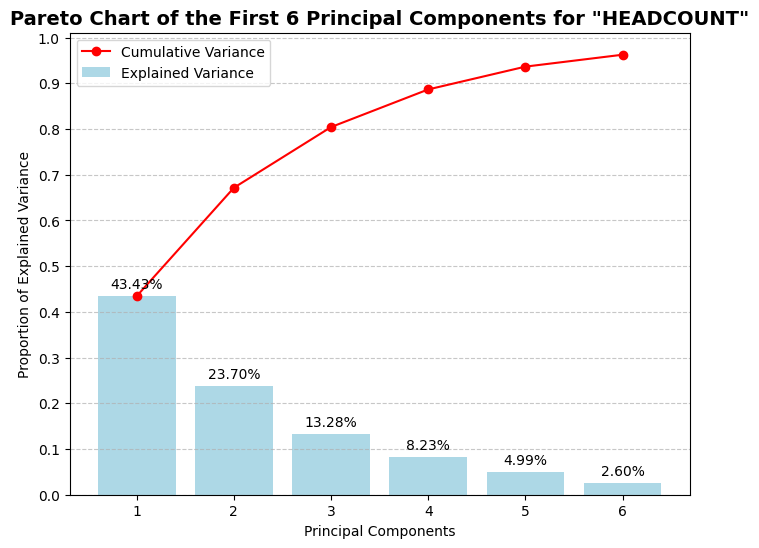

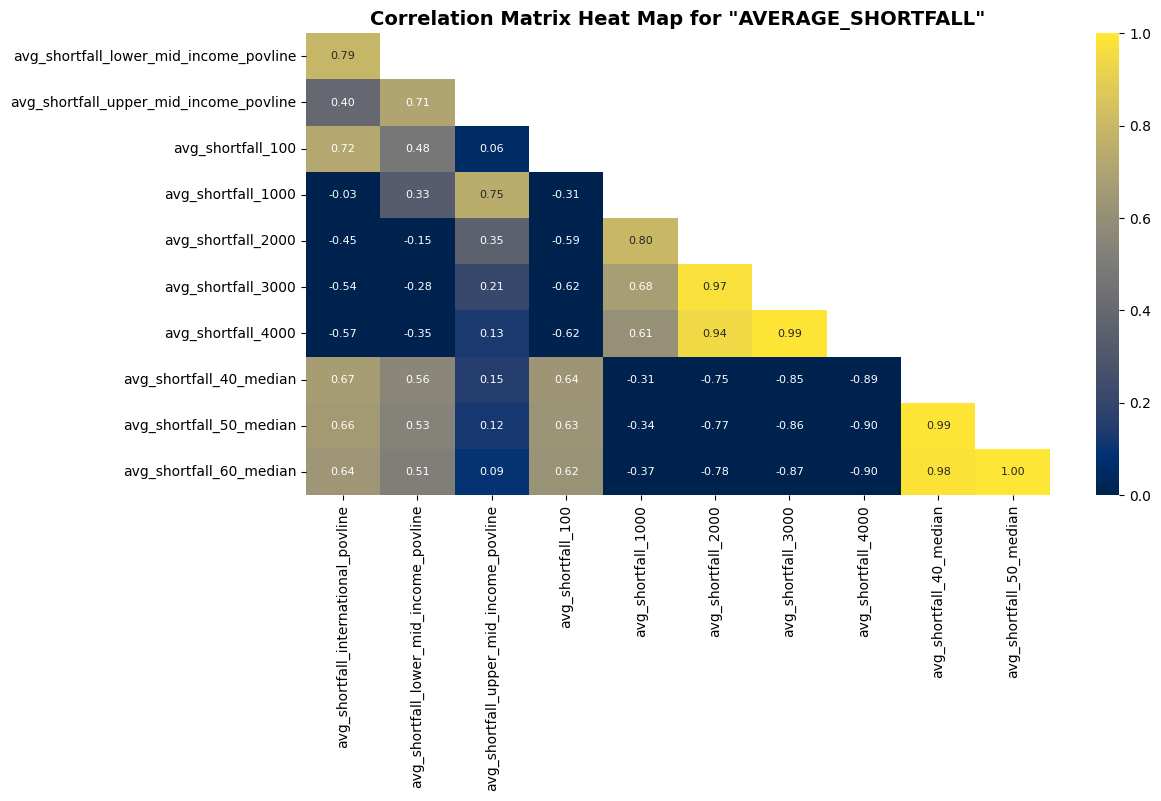

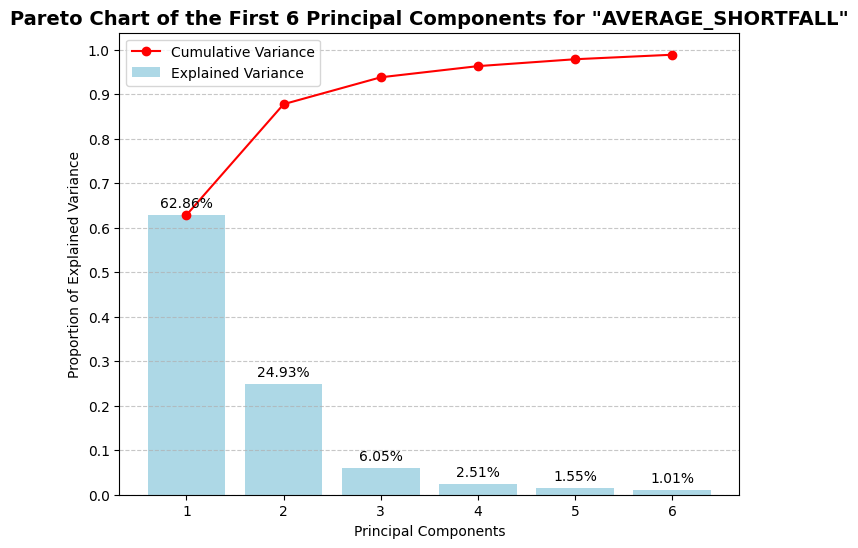

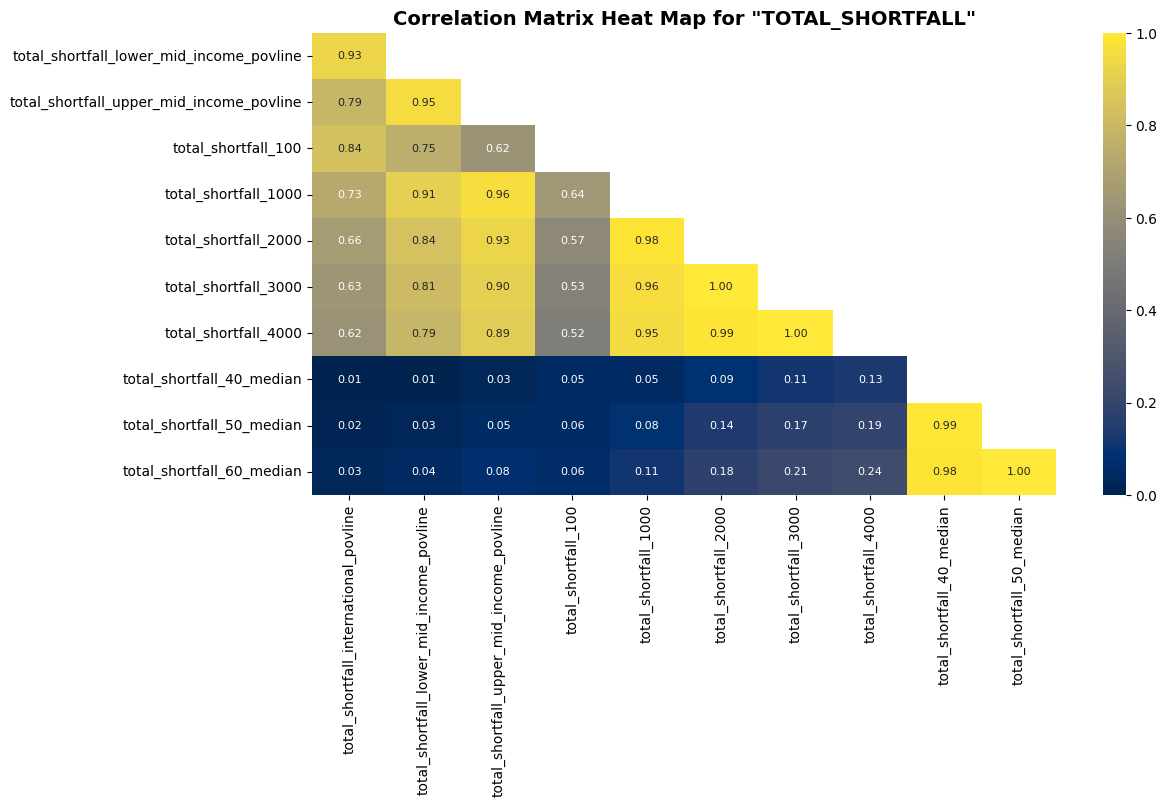

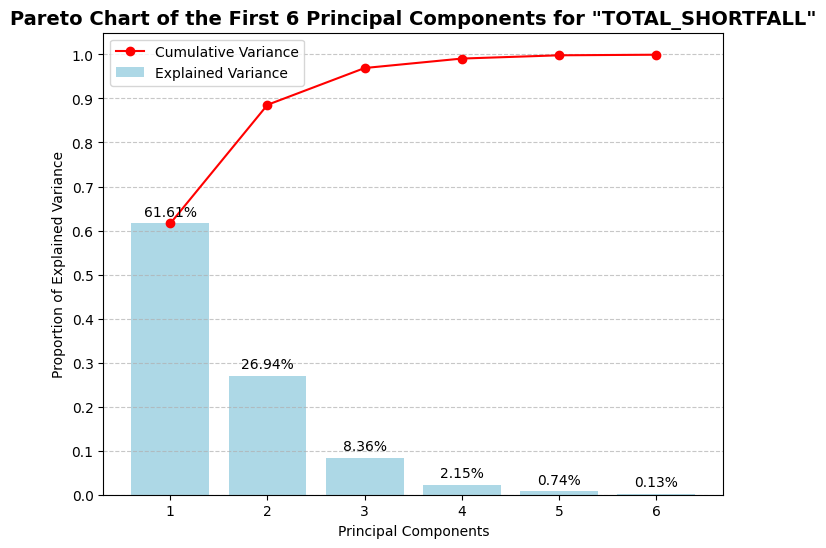

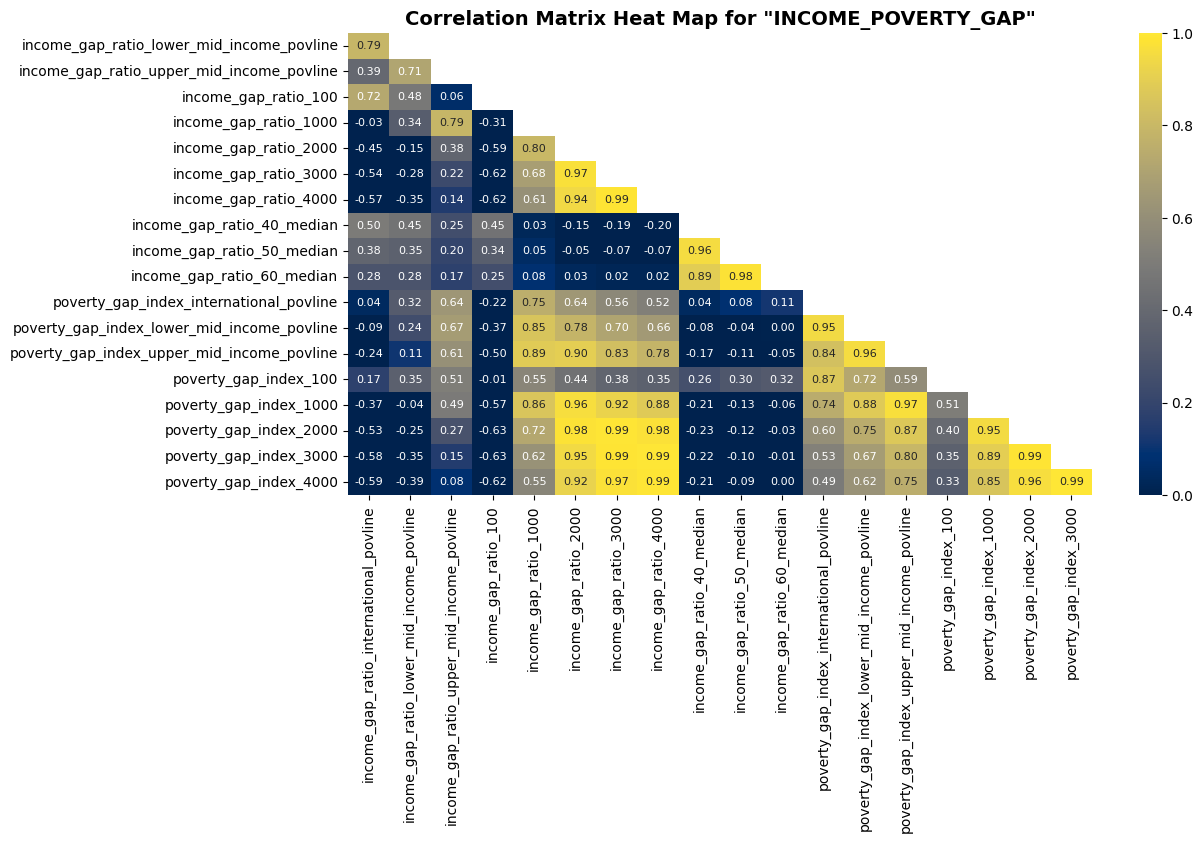

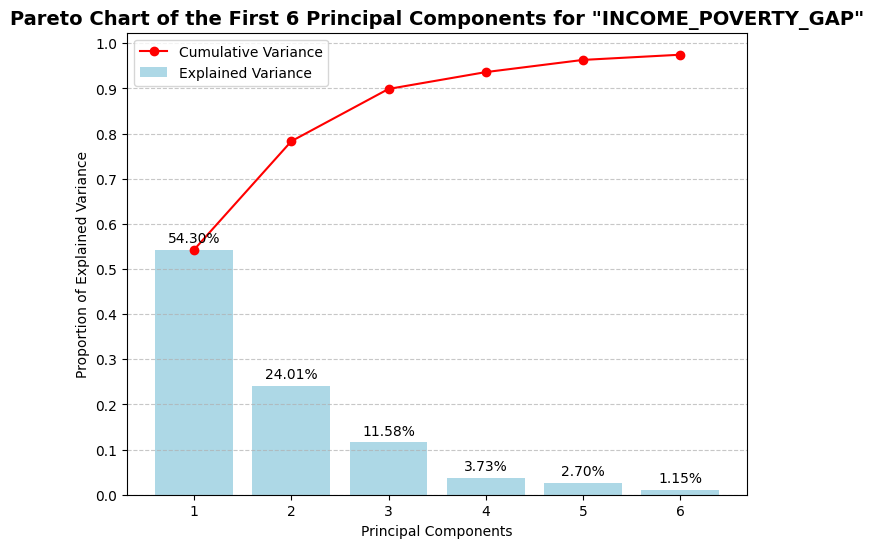

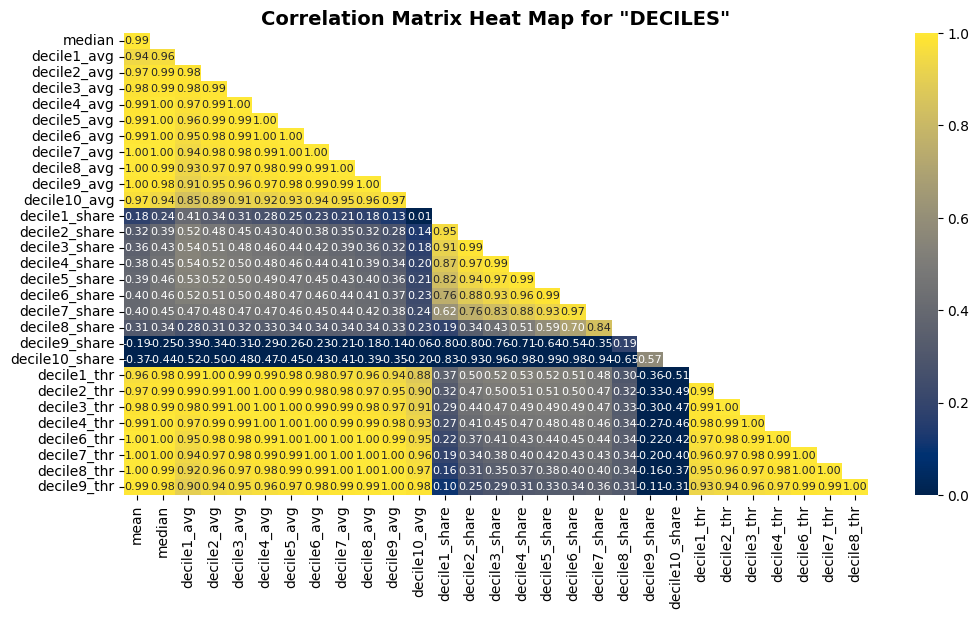

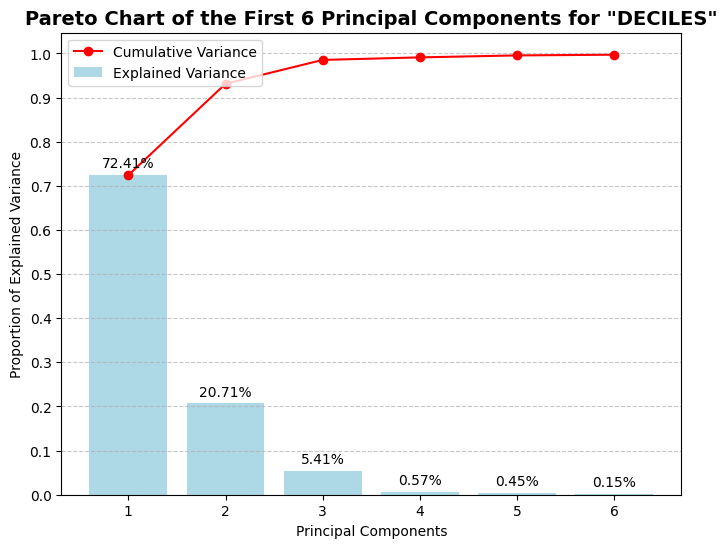

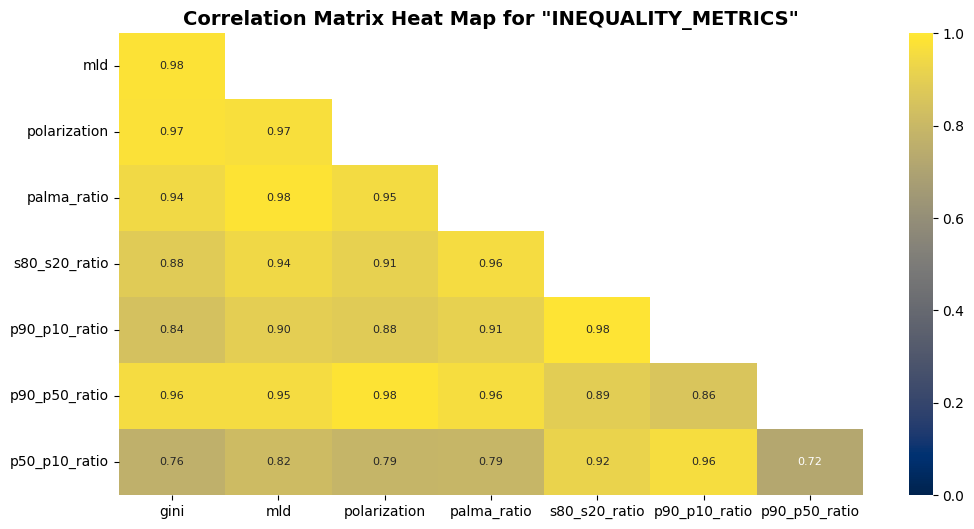

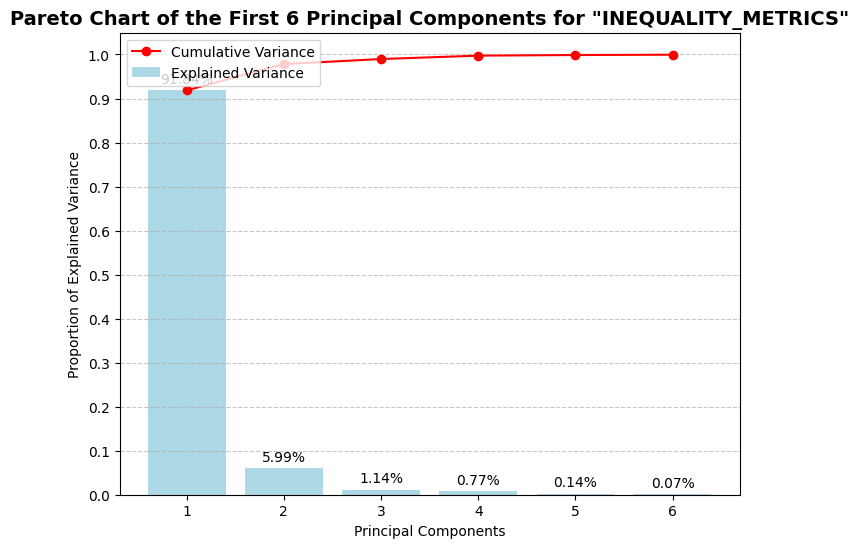

In [159]:
dataset_PCA = data.iloc[:, :7]

for name, dataset in datasets.items():

    ## CORRELATION MATRIX HEAT MAP
    corr_num = dataset.corr()
    mask = np.triu(np.ones_like(corr_num, dtype=bool)) # A mask to hide the upper right part of the matrix (it is duplicated)

    plt.figure(figsize=(12, 6))
    sns.heatmap(corr_num.iloc[1:, :-1], mask=mask[1:, :-1], annot=True, fmt=".2f",
                cmap="cividis", annot_kws={"size": 8}, vmin=0, vmax=1)
    plt.title(f'Correlation Matrix Heat Map for "{name.upper()}"', fontdict={'fontsize': 14, 'weight': 'bold'})
    plt.show()

    ## PCA & PARETO CHART
    # Standarise using Z-score
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(dataset)

    pca = PCA()
    pca_data = pca.fit_transform(data_standardized)
    explained_variance = pca.explained_variance_ratio_

    # Select the first N components
    n_components = 6
    explained_variance_N = explained_variance[:n_components]
    cumulative_variance_N = np.cumsum(explained_variance_N)

    # Pareto Chart
    plt.figure(figsize=(8, 6))
    components = np.arange(1, n_components+1)

    # Explained and cumulative variance
    plt.bar(components, explained_variance_N, color='lightblue', label="Explained Variance")
    plt.plot(components, cumulative_variance_N, marker='o', color='r', label="Cumulative Variance")

    plt.xlabel("Principal Components")
    plt.ylabel("Proportion of Explained Variance")
    plt.title(f'Pareto Chart of the First {n_components} Principal Components for "{name.upper()}"', fontdict={'fontsize': 14, 'weight': 'bold'})

    # Alabels with the percentage variability
    for i in range(len(components)):
        plt.text(components[i], explained_variance_N[i] + 0.01, f"{explained_variance_N[i]:.2%}", ha='center', va='bottom', fontsize=10)
    
    plt.xticks(components)
    plt.legend(loc='upper left', title_fontsize='medium', prop={'size': 10})
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))  # Set grid lines every 0.1 on the y-axis
    plt.show()

    # Select and store the minimum number of components needed to reach 90% cumulative variance
    n_components_90 = np.argmax(cumulative_variance_N >= 0.90) + 1  # Number of components needed for 90%
    pca_columns = [f"{name}_PCA{i+1}" for i in range(n_components_90)]
    dataset_PCA_subset = pd.DataFrame(pca_data[:, :n_components_90], columns=pca_columns)
    dataset_PCA = pd.concat([dataset_PCA, dataset_PCA_subset], axis=1)

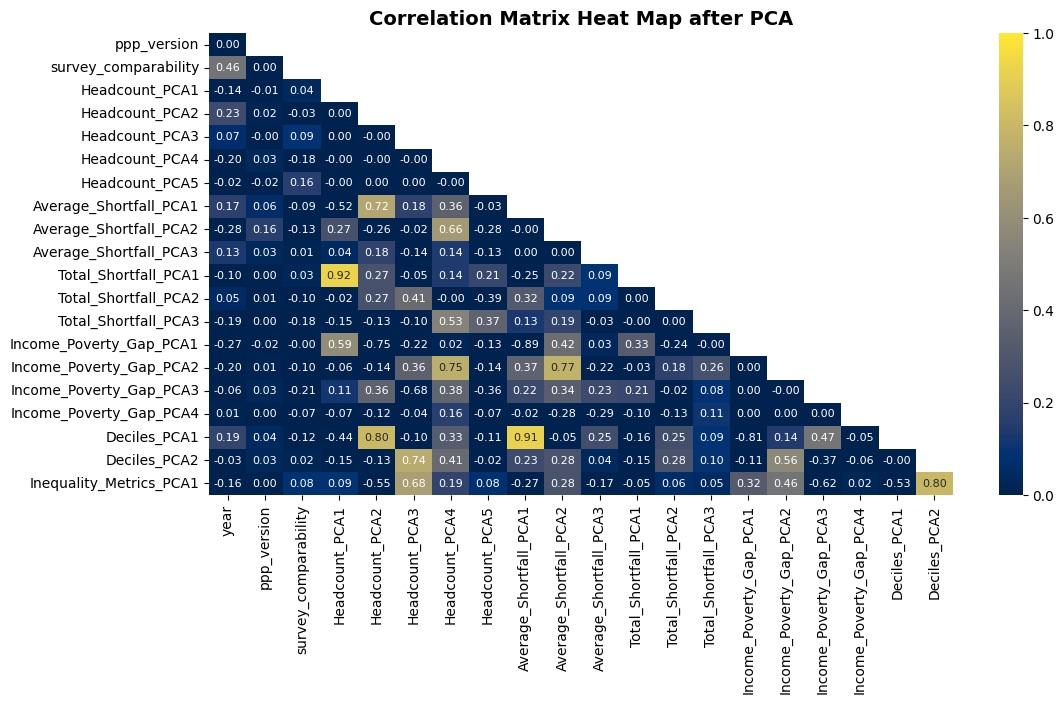

In [160]:
dataset_PCA
feat_names = dataset_PCA.columns
feat_num = [feat for feat in feat_names if feat not in feat_cat]

## CORRELATION MATRIX HEAT MAP
corr_num = dataset_PCA[feat_num].corr()
mask = np.triu(np.ones_like(corr_num, dtype=bool)) # A mask to hide the upper right part of the matrix (it is duplicated)

plt.figure(figsize=(12, 6))
sns.heatmap(corr_num.iloc[1:, :-1], mask=mask[1:, :-1], annot=True, fmt=".2f",
        cmap="cividis", annot_kws={"size": 8}, vmin=0, vmax=1)
plt.title(f'Correlation Matrix Heat Map after PCA', fontdict={'fontsize': 14, 'weight': 'bold'})
plt.show()

### 5. Análisis cluster <a class="anchor" id="seccion_5"></a>

Clustering con k-means. Buscamos el nº de clusters óptimos así como las variables más discriminativas por medio de Silhouette Score y Calinski-Harabasz Index. 
- **Silhouette Score**: mide la cohesión dentro de un cluster en comparación con otros clusters (separación). Valores entre -1 y 1 (1 perfectamente asignado, 0 en el borde entre clusters, -1 asignado al cluster incorrecto). Funciona bien para clusters bien separados.
- **Calinski-Harabasz Index**: evalúa el clustering mediante un cociente CH = varianza intercluster / varianza intracluster, por lo que valores más altos indican mejor separación y menor dispersión interna. Es más eficiente computacionalmente

In [161]:
# Prepare environment
var1_clutering = 'Inequality_Metrics_PCA1'
# var1_clutering = 'Deciles_PCA1'
# var1_clutering = 'Total_Shortfall_PCA1'
var2_clutering = 'Average_Shortfall_PCA1'
# var2_clutering = 'Headcount_PCA1'
X = dataset_PCA.iloc[:, 7:]

k_values = range(2, 9)
silhouette_scores = []
ch_scores = []

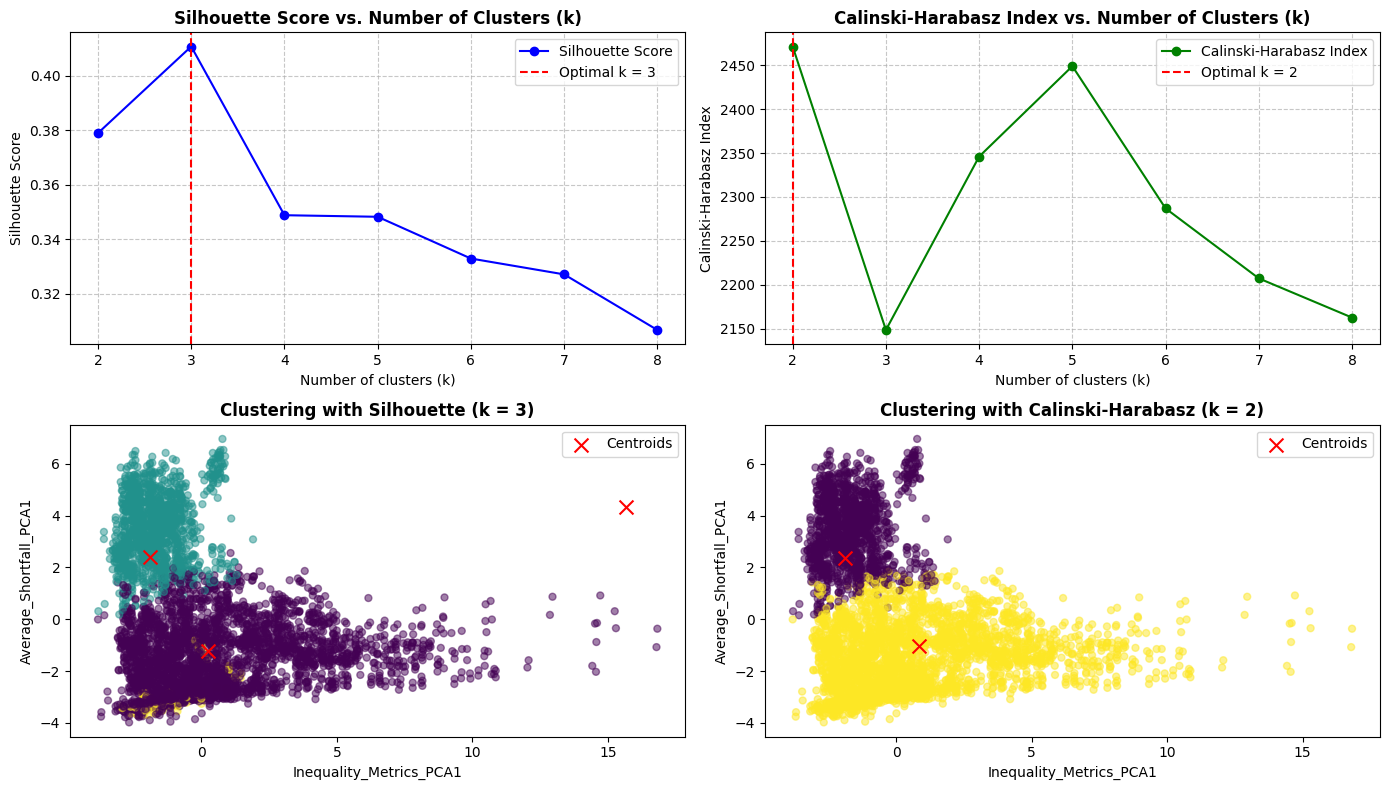

In [162]:
# Loop through each k value and calculate both metrics
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))  # Silhouette Score
    ch_scores.append(calinski_harabasz_score(X, labels))   # Calinski-Harabasz Index

optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
optimal_k_ch = k_values[np.argmax(ch_scores)]

# Perform clustering with the optimal k for both methods
kmeans_silhouette = KMeans(n_clusters=optimal_k_silhouette, random_state=0, n_init=10)
labels_silhouette = kmeans_silhouette.fit_predict(X)
kmeans_ch = KMeans(n_clusters=optimal_k_ch, random_state=0, n_init=10)
labels_ch = kmeans_ch.fit_predict(X)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot Silhouette Score vs. k
axes[0, 0].plot(k_values, silhouette_scores, marker='o', linestyle='-', color='blue', label='Silhouette Score')
axes[0, 0].axvline(optimal_k_silhouette, color='red', linestyle='--', label=f'Optimal k = {optimal_k_silhouette}')
axes[0, 0].set_title("Silhouette Score vs. Number of Clusters (k)", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[0, 0].set_xlabel("Number of clusters (k)")
axes[0, 0].set_ylabel("Silhouette Score")
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle='--', alpha=0.7)

# Scatter plot for Silhouette optimal clustering
axes[1, 0].scatter(dataset_PCA[var1_clutering], dataset_PCA[var2_clutering], c=labels_silhouette, cmap='viridis', s=25, alpha=0.5)
axes[1, 0].scatter(kmeans_silhouette.cluster_centers_[:, 0], kmeans_silhouette.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
axes[1, 0].set_title(f"Clustering with Silhouette (k = {optimal_k_silhouette})", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[1, 0].set_xlabel(var1_clutering)
axes[1, 0].set_ylabel(var2_clutering)
axes[1, 0].legend()

# Plot Calinski-Harabasz Index vs. k
axes[0, 1].plot(k_values, ch_scores, marker='o', linestyle='-', color='green', label='Calinski-Harabasz Index')
axes[0, 1].axvline(optimal_k_ch, color='red', linestyle='--', label=f'Optimal k = {optimal_k_ch}')
axes[0, 1].set_title("Calinski-Harabasz Index vs. Number of Clusters (k)", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[0, 1].set_xlabel("Number of clusters (k)")
axes[0, 1].set_ylabel("Calinski-Harabasz Index")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle='--', alpha=0.7)

# Scatter plot for Calinski-Harabasz optimal clustering
axes[1, 1].scatter(dataset_PCA[var1_clutering], dataset_PCA[var2_clutering], c=labels_ch, cmap='viridis', s=25, alpha=0.5)
axes[1, 1].scatter(kmeans_ch.cluster_centers_[:, 0], kmeans_ch.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
axes[1, 1].set_title(f"Clustering with Calinski-Harabasz (k = {optimal_k_ch})", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[1, 1].set_xlabel(var1_clutering)
axes[1, 1].set_ylabel(var2_clutering)
axes[1, 1].legend()

plt.tight_layout()
plt.show()


Probamos también con los métodos Davies-Bouldin Index y el método del codo (Elbow Method).
- **Davies-Bouldin Index**: mide la calidad del clustering comparando  la dispersión interna de los clusters y la distancia entre ellos. Valores más bajos indican una mejor separación entre clusters y una menor dispersión dentro de cada cluster. Útil cuando los clusters no están claramente separados.
- **Elbow Method**: evalúa el clustering observando la inercia, que mide la suma de las distancias cuadradas de los puntos al centroide del cluster. El número óptimo de clusters se identifica en el "codo" del gráfico, donde la inercia comienza a reducirse significativamente. Método visual y eficiente computacionalmente.

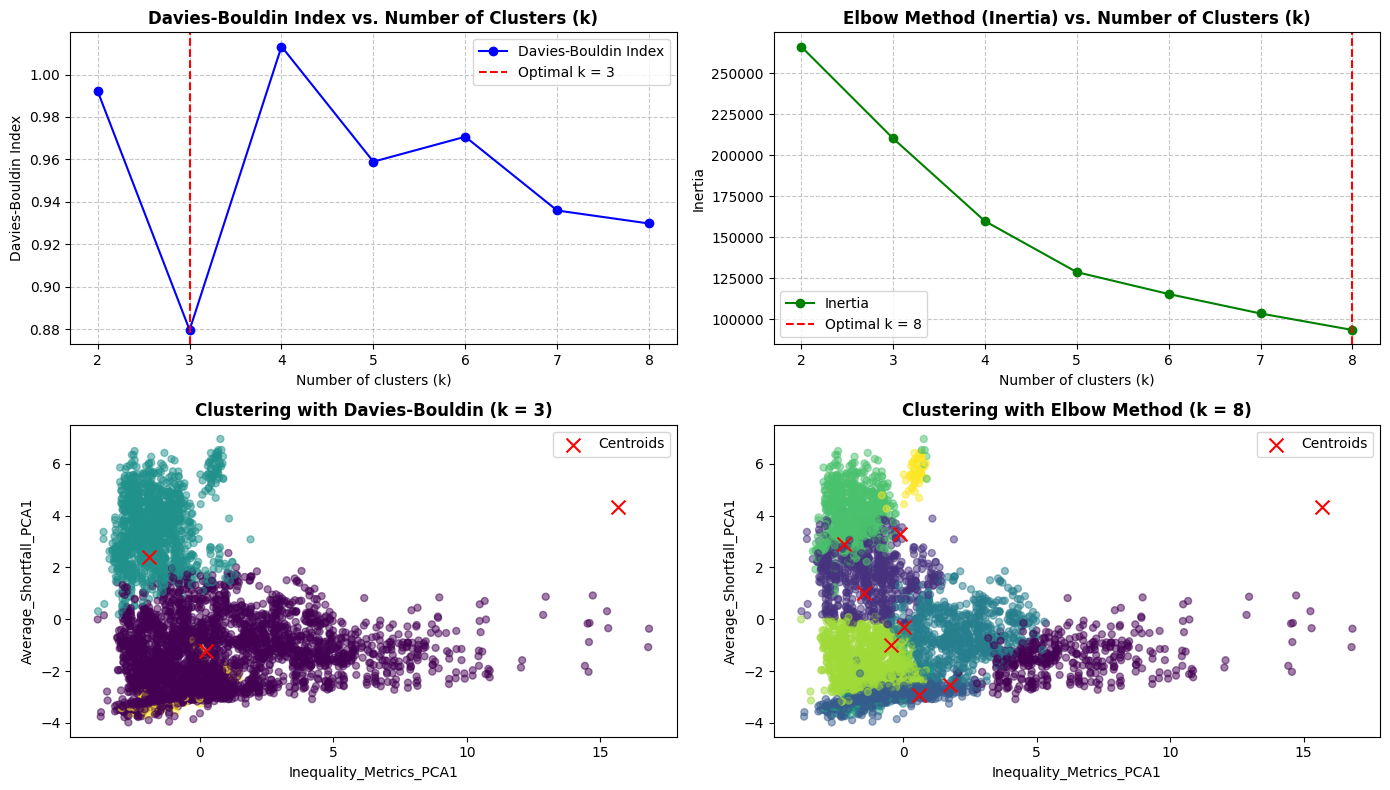

In [ ]:
db_scores = []
inertia = []

# Loop through each k value and calculate both metrics hola
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(X)
    
    db_scores.append(davies_bouldin_score(X, labels))
    inertia.append(kmeans.inertia_)

# Find the optimal k for both methods
optimal_k_db = k_values[np.argmin(db_scores)]  # Menor DB
optimal_k_elbow = k_values[np.argmin(np.gradient(np.gradient(inertia)))]  # Codo

# Perform clustering with the optimal k for both methods
kmeans_db = KMeans(n_clusters=optimal_k_db, random_state=0, n_init=10)
labels_db = kmeans_db.fit_predict(X)
kmeans_elbow = KMeans(n_clusters=optimal_k_elbow, random_state=0, n_init=10)
labels_elbow = kmeans_elbow.fit_predict(X)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot Davies-Bouldin Index vs. k
axes[0, 0].plot(k_values, db_scores, marker='o', linestyle='-', color='blue', label='Davies-Bouldin Index')
axes[0, 0].axvline(optimal_k_db, color='red', linestyle='--', label=f'Optimal k = {optimal_k_db}')
axes[0, 0].set_title("Davies-Bouldin Index vs. Number of Clusters (k)", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[0, 0].set_xlabel("Number of clusters (k)")
axes[0, 0].set_ylabel("Davies-Bouldin Index")
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle='--', alpha=0.7)

# Scatter plot for Davies-Bouldin optimal clustering
axes[1, 0].scatter(dataset_PCA[var1_clutering], dataset_PCA[var2_clutering], c=labels_db, cmap='viridis', s=25, alpha=0.5)
axes[1, 0].scatter(kmeans_db.cluster_centers_[:, 0], kmeans_db.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
axes[1, 0].set_title(f"Clustering with Davies-Bouldin (k = {optimal_k_db})", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[1, 0].set_xlabel(var1_clutering)
axes[1, 0].set_ylabel(var2_clutering)
axes[1, 0].legend()

# Plot Elbow Method (Inertia) vs. k
axes[0, 1].plot(k_values, inertia, marker='o', linestyle='-', color='green', label='Inertia')
axes[0, 1].axvline(optimal_k_elbow, color='red', linestyle='--', label=f'Optimal k = {optimal_k_elbow}')
axes[0, 1].set_title("Elbow Method (Inertia) vs. Number of Clusters (k)", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[0, 1].set_xlabel("Number of clusters (k)")
axes[0, 1].set_ylabel("Inertia")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle='--', alpha=0.7)

# Scatter plot for Elbow optimal clustering
axes[1, 1].scatter(dataset_PCA[var1_clutering], dataset_PCA[var2_clutering], c=labels_elbow, cmap='viridis', s=25, alpha=0.5)
axes[1, 1].scatter(kmeans_elbow.cluster_centers_[:, 0], kmeans_elbow.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
axes[1, 1].set_title(f"Clustering with Elbow Method (k = {optimal_k_elbow})", fontdict={'fontsize': 12, 'weight': 'bold'})
axes[1, 1].set_xlabel(var1_clutering)
axes[1, 1].set_ylabel(var2_clutering)
axes[1, 1].legend()

plt.tight_layout()
plt.show()


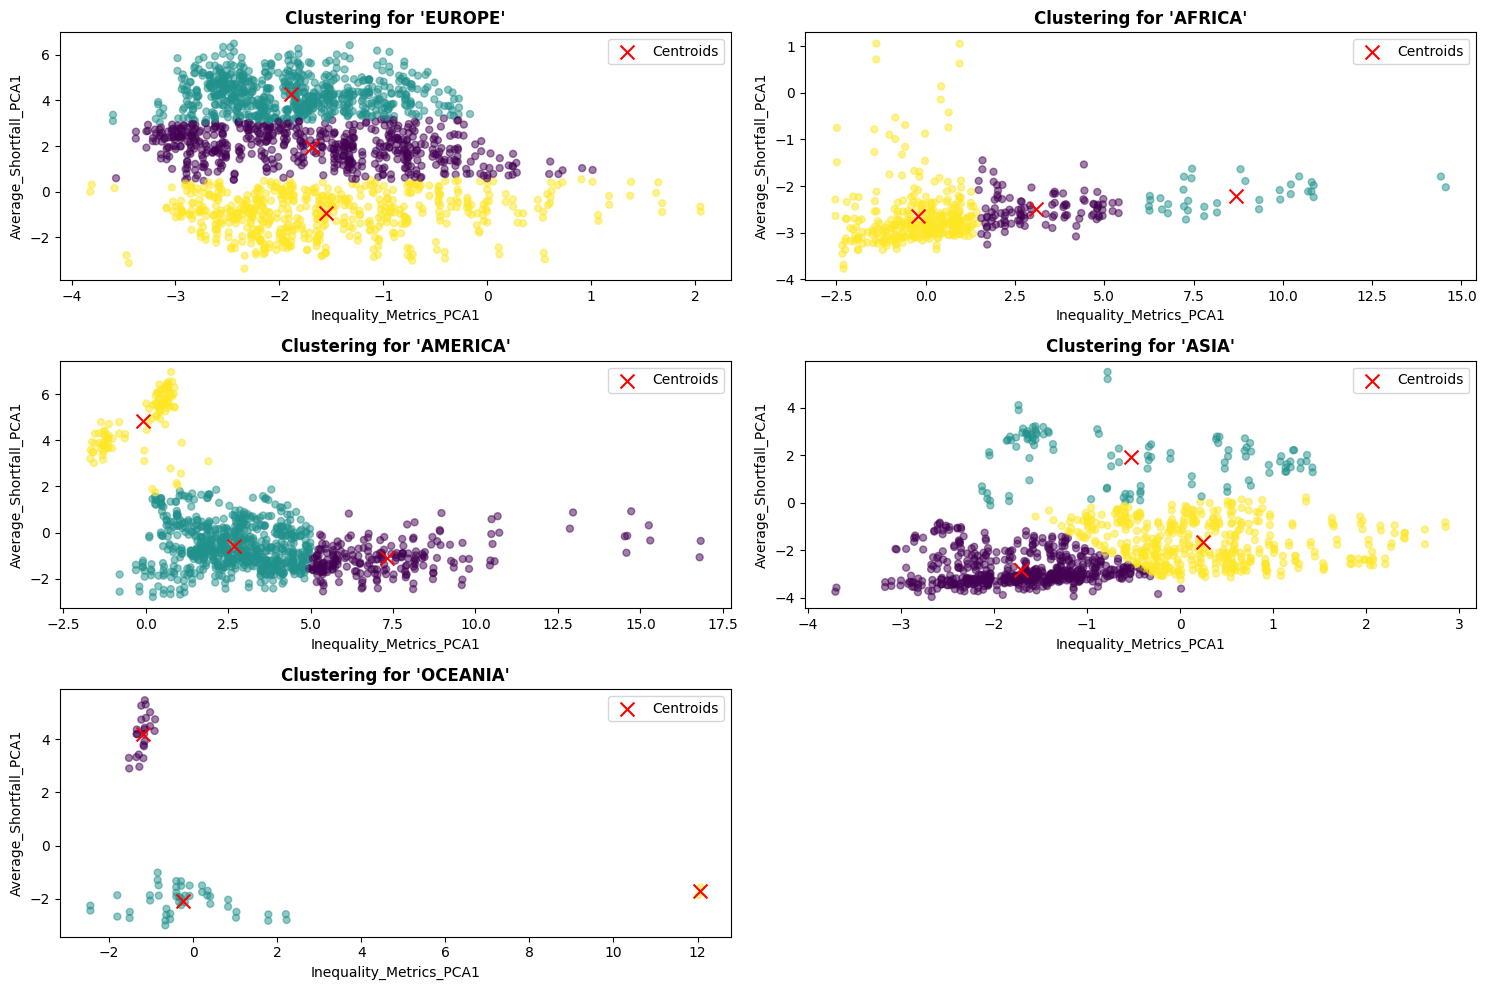

In [164]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()  # Flatten axes for easy iteration
continents = dataset_PCA['continent'].unique()
num_continents = len(continents)

# Calculate the global min and max for the variables
var1_min, var1_max = dataset_PCA[var1_clutering].min(), dataset_PCA[var1_clutering].max()
var2_min, var2_max = dataset_PCA[var2_clutering].min(), dataset_PCA[var2_clutering].max()

# Loop through each continent and plot in the subplots
for i, continent in enumerate(continents):
    # Filter the data for the current continent
    continent_data = dataset_PCA[dataset_PCA['continent'] == continent]
    continent_data = continent_data.reset_index(drop=True)  # Reiniciar el índice del subconjunto
    X = continent_data[[var1_clutering, var2_clutering]]

    # Check if the data is sufficient for clustering
    if len(X) < 2:
        print(f"Skipping {continent}: not enough data points for clustering.")
        continue
    
    # Clustering method
    k = 3
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    continent_data['Cluster'] = kmeans.fit_predict(X)
    
    # Plot on the corresponding subplot
    ax = axes[i]
    scatter = ax.scatter(continent_data[var1_clutering], continent_data[var2_clutering], 
                         c=continent_data['Cluster'], cmap='viridis', s=25, alpha=0.5)
    ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
               c='red', marker='x', s=100, label='Centroids')
    ax.set_title(f"Clustering for '{continent.upper()}'", fontdict={'weight': 'bold', 'size': 12})
    ax.set_xlabel(var1_clutering)
    ax.set_ylabel(var2_clutering)
    ax.legend()
    # ax.set_xlim(var1_min-0.05, var1_max+0.05)
    # ax.set_ylim(var2_min-0.5, var2_max+0.5)

# Remove empty subplots if there are fewer continents
if num_continents < len(axes):
    for j in range(num_continents, len(axes)):
        fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


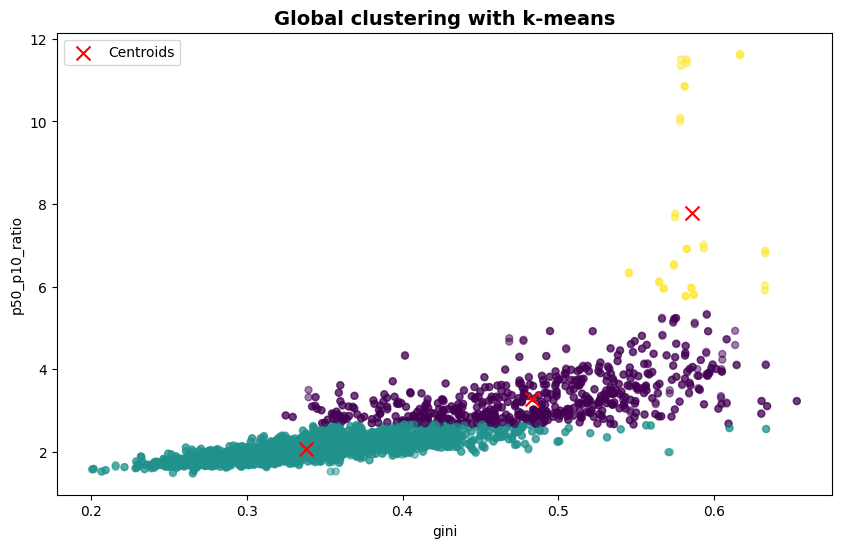

In [165]:
X = data[['gini', 'p50_p10_ratio']]

# Clustering method
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
dataset_PCA['Cluster'] = kmeans.fit_predict(X)  

# Scatter plot of the results after clustering
plt.figure(figsize=(10, 6))
plt.scatter(data['gini'], data['p50_p10_ratio'], c=dataset_PCA['Cluster'], cmap='viridis', s=25, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title("Global clustering with k-means", fontdict={'fontsize': 14, 'weight': 'bold'})
plt.xlabel("gini")
plt.ylabel("p50_p10_ratio")
plt.legend()
plt.show()

### KK (ANÁLISIS GLOBAL)

In [166]:
feat_names = data.columns
feat_cat = list(feat_names[0:2]) + list(feat_names[3:5])
feat_num = [feat for feat in feat_names if feat not in feat_cat]
dataset = data[feat_num]
dataset = dataset.iloc[:, :-8]
dataset

year  ppp_version  survey_comparability  \
0     1996.0       2011.0                   0.0   
1     2002.0       2011.0                   1.0   
2     2005.0       2011.0                   1.0   
3     2008.0       2011.0                   1.0   
4     2012.0       2011.0                   1.0   
...      ...          ...                   ...   
4390  2006.0       2017.0                   3.0   
4391  2010.0       2017.0                   4.0   
4392  2015.0       2017.0                   4.0   
4393  2011.0       2017.0                   0.0   
4394  2017.0       2017.0                   0.0   

      headcount_ratio_international_povline  \
0                                  0.920669   
1                                  1.570843   
2                                  0.860527   
3                                  0.313650   
4                                  0.849754   
...                                     ...   
4390                              64.698028   
4391                              68.456606   
4392                              61.352160   
4393                              21.580063   
4394                              34.206046   

      headcount_ratio_lower_mid_income_povline  \
0                                    11.174149   
1                                    14.132118   
2                                     8.715685   
3                                     5.250542   
4                                     6.182414   
...                                        ...   
4390                                 81.165271   
4391                                 82.885088   
4392                                 77.548045   
4393                                 47.857143   
4394                                 61.583570   

      headcount_ratio_upper_mid_income_povline  headcount_ratio_100  \
0                                    44.618417             0.057416   
1                                    49.669635             0.046371   
2                                    38.545254             0.027620   
3                                    31.110345             0.000000   
4                                    34.528906             0.111321   
...                                        ...                  ...   
4390                                 92.573347            33.916066   
4391                                 93.044964            36.476496   
4392                                 90.747141            34.330914   
4393                                 77.945113             0.351729   
4394                                 84.109019             2.398895   

      headcount_ratio_1000  headcount_ratio_2000  headcount_ratio_3000  ...  \
0                86.175208             99.632079             99.912465  ...   
1                85.338317             98.080061             99.638386  ...   
2                79.987127             97.576598             99.434458  ...   
3                75.851021             97.099785             99.015864  ...   
4                77.069840             97.772626             99.618299  ...   
...                    ...                   ...                   ...  ...   
4390             96.002132             99.070190             99.672053  ...   
4391             96.299710             99.003962             99.620898  ...   
4392             95.074710             98.777883             99.451535  ...   
4393             88.905316             97.352365             98.956205  ...   
4394             92.461215             98.468333             99.412651  ...   

      decile9_share  decile10_share  decile1_thr  decile2_thr  decile3_thr  \
0         14.899548       21.215573         3.06         3.88         4.48   
1         14.925078       25.435637         2.91         3.62         4.22   
2         14.833943       24.341168         3.30         4.18         4.93   
3         14.535204       24.458311         3.81         4.70         5.43   
4         14.889137       22.934340  

ANÁLISIS GLOBAL DE CORRELACIONES + PCA

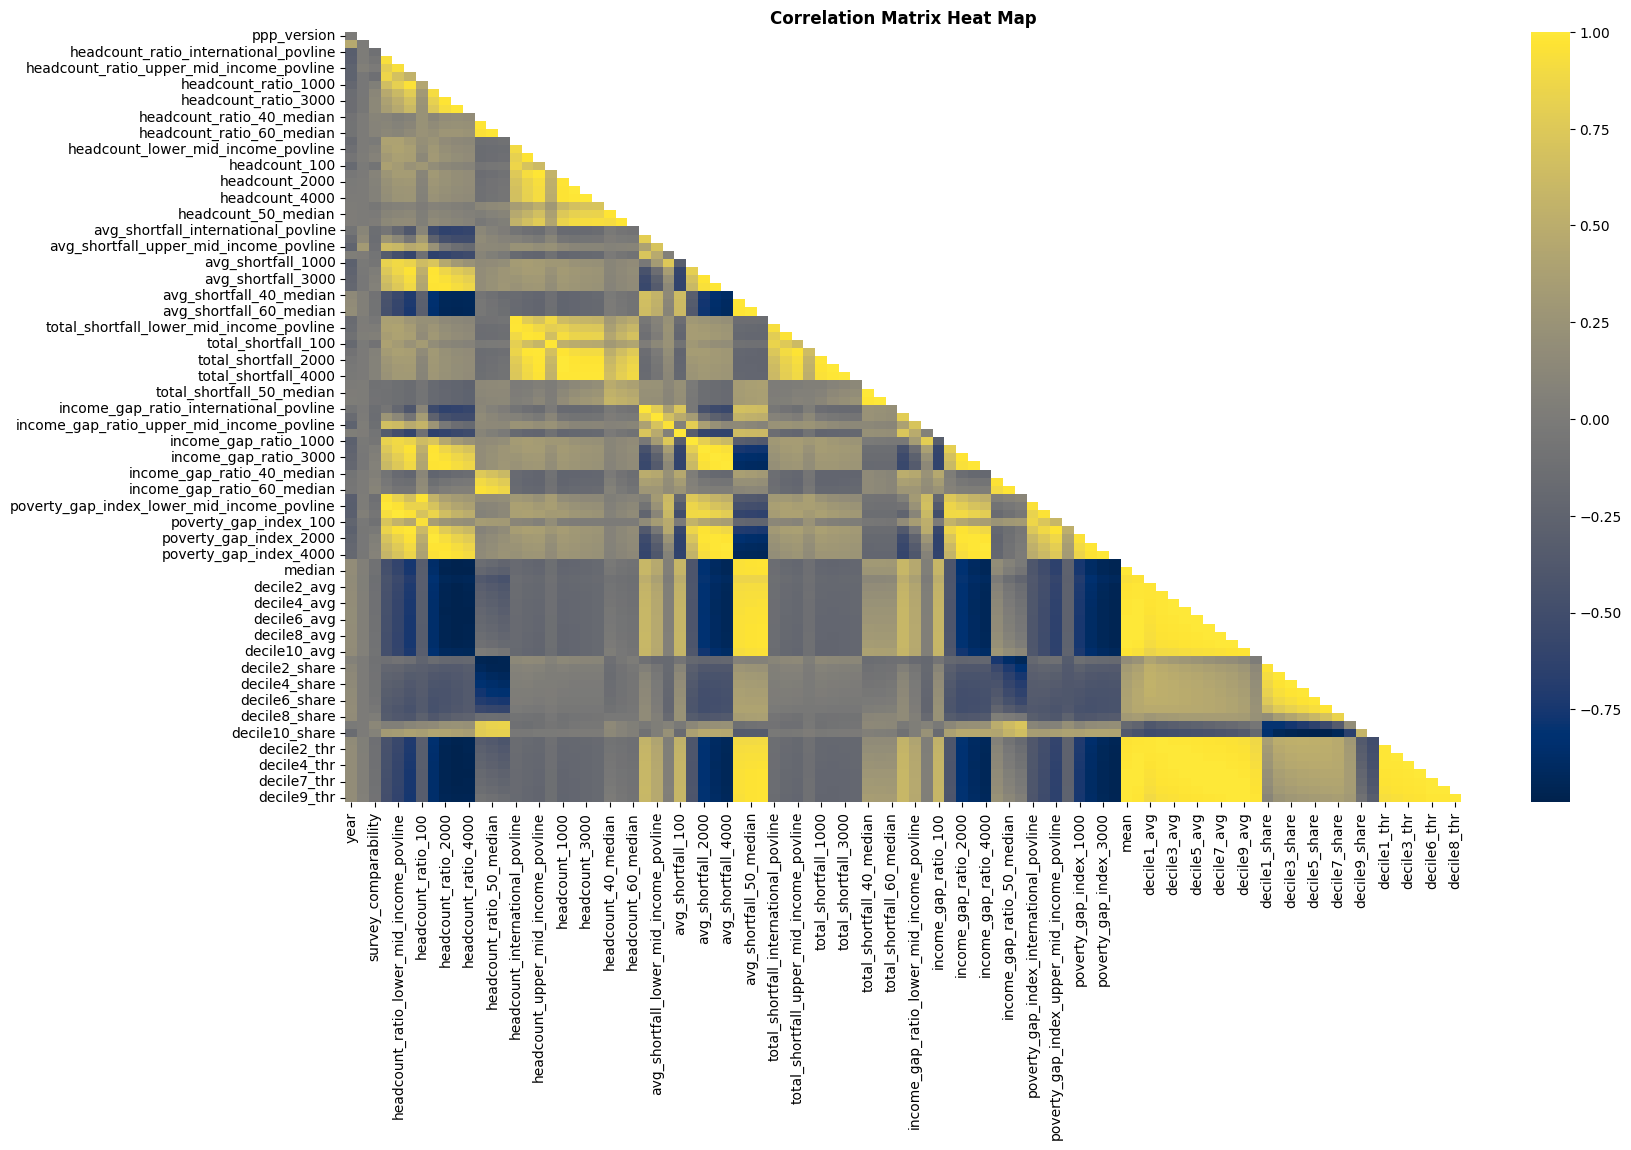

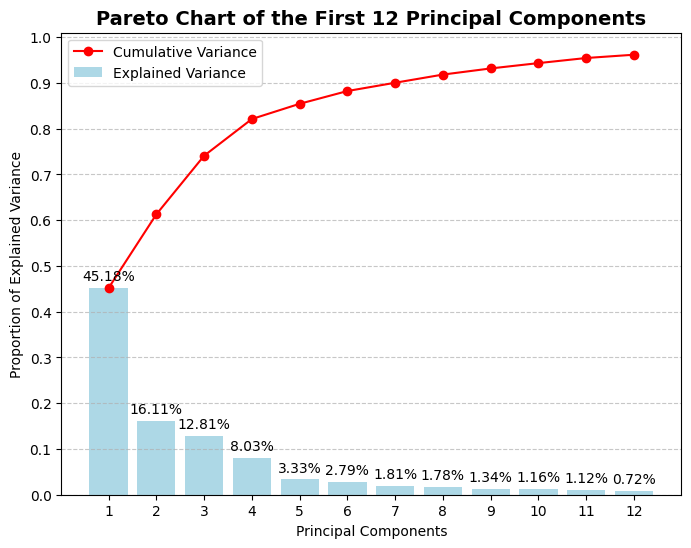

In [167]:

## CORRELATION MATRIX HEAT MAP
corr_num = dataset.corr()
mask = np.triu(np.ones_like(corr_num, dtype=bool)) # A mask to hide the upper right part of the matrix (it is duplicated)

plt.figure(figsize=(18, 10))  # Aumenta el tamaño del gráfico para acomodar más etiquetas
sns.heatmap(corr_num.iloc[1:, :-1], mask=mask[1:, :-1], annot=False, fmt=".2f", cmap="cividis", annot_kws={"size": 5})
# 
# Configuración del título
plt.title('Correlation Matrix Heat Map', fontdict={'fontsize': 12, 'weight': 'bold'})

# Ajustar etiquetas de los ejes
plt.xticks(rotation=90, fontsize=10)  # Rotar las etiquetas del eje X y reducir el tamaño de fuente
plt.yticks(fontsize=10)  # Reducir el tamaño de fuente de las etiquetas del eje Y

plt.show()

## PCA & PARETO CHART
# Standarise using Z-score
scaler = StandardScaler()
data_standardized = scaler.fit_transform(dataset)

pca = PCA()
pca_data = pca.fit_transform(data_standardized)
explained_variance = pca.explained_variance_ratio_

# Select the first N components
n_components = 12
explained_variance_N = explained_variance[:n_components]
cumulative_variance_N = np.cumsum(explained_variance_N)

# Pareto Chart
plt.figure(figsize=(8, 6))
components = np.arange(1, n_components+1)

# Explained and cumulative variance
plt.bar(components, explained_variance_N, color='lightblue', label="Explained Variance")
plt.plot(components, cumulative_variance_N, marker='o', color='r', label="Cumulative Variance")

plt.xlabel("Principal Components")
plt.ylabel("Proportion of Explained Variance")
plt.title(f'Pareto Chart of the First {n_components} Principal Components', fontdict={'fontsize': 14, 'weight': 'bold'})

# Alabels with the percentage variability
for i in range(len(components)):
    plt.text(components[i], explained_variance_N[i] + 0.01, f"{explained_variance_N[i]:.2%}", ha='center', va='bottom', fontsize=10)

plt.xticks(components)
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_locator(MultipleLocator(0.1))  # Set grid lines every 0.1 on the y-axis
plt.show()

# Select and store the minimum number of components needed to reach 90% cumulative variance
n_components_90 = np.argmax(cumulative_variance_N >= 0.90) + 1  # Number of components needed for 90%
pca_columns = [f"{name}_PCA{i+1}" for i in range(n_components_90)]
dataset_PCA_subset = pd.DataFrame(pca_data[:, :n_components_90], columns=pca_columns)
dataset_PCA = pd.concat([dataset_PCA, dataset_PCA_subset], axis=1)